<a href="https://colab.research.google.com/github/OplopanaxHorridus/Yolov7_TrashNet/blob/main/Yolo_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git

Cloning into 'yolov7'...
remote: Enumerating objects: 1191, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1191 (delta 2), reused 5 (delta 2), pack-reused 1185
Receiving objects: 100% (1191/1191), 74.23 MiB | 23.84 MiB/s, done.
Resolving deltas: 100% (514/514), done.


In [ ]:
#Make sure you have GPU
!nvidia-smi

Mon Jul 24 16:34:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    63W / 400W |      0MiB / 40960MiB |     75%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

If you get "CUDA is unavailable":
1. Click Runtime at the top
2. Change runtime type (GPU from hardware accelerator)
3. Click save



1.   Add both datasets into content/
2.   Also make sure you put  yolov7-custom.yaml in cfg/training
3.   Put data.yaml in data folder

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import shutil
import PIL
import tensorflow as tf
import PIL.Image
import zipfile

!unzip -o '/content/trash_net' -d '/content'
!unzip -o '/content/yolo_labels' -d '/content'


Streaming output truncated to the last 5000 lines.
  inflating: /content/trash_net/cardboard/cardboard146.jpg  
  inflating: /content/trash_net/cardboard/cardboard147.jpg  
  inflating: /content/trash_net/cardboard/cardboard148.jpg  
  inflating: /content/trash_net/cardboard/cardboard149.jpg  
  inflating: /content/trash_net/cardboard/cardboard15.jpg  
  inflating: /content/trash_net/cardboard/cardboard150.jpg  
  inflating: /content/trash_net/cardboard/cardboard151.jpg  
  inflating: /content/trash_net/cardboard/cardboard152.jpg  
  inflating: /content/trash_net/cardboard/cardboard153.jpg  
  inflating: /content/trash_net/cardboard/cardboard154.jpg  
  inflating: /content/trash_net/cardboard/cardboard155.jpg  
  inflating: /content/trash_net/cardboard/cardboard156.jpg  
  inflating: /content/trash_net/cardboard/cardboard157.jpg  
  inflating: /content/trash_net/cardboard/cardboard158.jpg  
  inflating: /content/trash_net/cardboard/cardboard159.jpg  
  inflating: /content/trash_net/car

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




```
`# This is formatted as code`
```

In CFG folder and in Data Folder created yolov7-custom.yaml file and created data.yaml file to go with trashnet

Check where this code is running, and that you correctly downloaded git hub and you have your trash_net.zip and yolo_labels.zip. Code should be running in content for now, will  cd later into yolov7 when we want to train the network



In [ ]:
import os
#showing working directory because I imported from github

#Check the current working directory
print(os.getcwd())

#List the contents of the directory
print(os.listdir())

#Recursively search for the 'yolov7' directory
search_dir = os.getcwd()
for root, dirs, files in os.walk(search_dir):
    if 'yolov7' in dirs:
        yolov7_path = os.path.join(root, 'yolov7')
        break

#Check if the 'yolov7' directory is found
if 'yolov7_path' in locals():
    print(f"Found 'yolov7' directory at: {yolov7_path}")
else:
    print("Failed to locate 'yolov7' directory.")



/content
['.config', 'yolo_labels.zip', 'trash_net.zip', 'yolov7', 'yolo_labels', 'trash_net', 'sample_data']
Found 'yolov7' directory at: /content/yolov7


In [ ]:
base_dir = '/content/trash_net/'
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
!pip install split-folders
import splitfolders as sf

data_dir = '/content/trash_net_data'
sf.ratio(base_dir, # The location of dataset
        output='trash_net_data', # The output location
        seed=42, # The number of seed
        ratio=(.7, .2, .1), # The ratio of splited dataset
        group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
        move=False # If you choose to move, turn this into True
      )

Copying files: 2527 files [00:00, 8412.16 files/s]


In [ ]:
#Generates the YOLO dataset (since it needs labels)
yolo_dir = '/content/yolo_trash_net_data/'
label_dir = '/content/yolo_labels'

labels = glob.glob(label_dir + '/*.txt')
print("Labels: " + str(len(labels)))


for folder in ['test', 'train', 'val']:
  if not os.path.exists(os.path.join(yolo_dir, folder)):
      os.makedirs(os.path.join(yolo_dir, folder))
      os.makedirs(os.path.join(yolo_dir, folder, 'images'))
      os.makedirs(os.path.join(yolo_dir, folder, 'labels'))
  for cl in classes:
    img_path = os.path.join(data_dir,folder, cl)
    images = glob.glob(img_path + '/*.jpg')
    print("{} {}: {} Images".format(folder, cl, len(images)))
    for img in images:
      img_string = os.path.basename(img).replace('.jpg', '_jpg')
      label = list(filter(lambda x: img_string in x, labels))
      if len(label) == 1:
        label_name = os.path.basename(label[0])
        shutil.copy(img, os.path.join(yolo_dir, folder, 'images'))
        shutil.copy(label[0], os.path.join(yolo_dir, folder, 'labels'))
        dest_dir = os.path.join(yolo_dir, folder, 'labels')
        new_file = os.path.join(dest_dir, img_string.replace('_jpg', '.txt'))
        old_file = os.path.join(dest_dir, label_name)
        os.rename(old_file, new_file)

Labels: 2519
test cardboard: 41 Images
test glass: 51 Images
test metal: 41 Images
test paper: 61 Images
test plastic: 49 Images
test trash: 15 Images
train cardboard: 282 Images
train glass: 350 Images
train metal: 287 Images
train paper: 415 Images
train plastic: 337 Images
train trash: 95 Images
val cardboard: 80 Images
val glass: 100 Images
val metal: 82 Images
val paper: 118 Images
val plastic: 96 Images
val trash: 27 Images


In [ ]:
for folder in ['test', 'train', 'val']:
    img_path = os.path.join(yolo_dir, folder, 'images')
    images = glob.glob(img_path + '/*.jpg')
    label_path = os.path.join(yolo_dir, folder, 'labels')
    labels = glob.glob(label_path + '/*.txt')
    print("{}: {} Images".format(folder, len(images)))
    print("{}: {} Labels".format(folder, len(labels)))

test: 256 Images
test: 256 Labels
train: 1762 Images
train: 1762 Labels
val: 501 Images
val: 501 Labels


In [ ]:
#moving folders into github repo /data folder
import shutil

#Set the paths for source and destination directories
source_dir = '/content/yolo_trash_net_data'
destination_dir = '/content/yolov7/data'

#Move each folder (test, train, val) from source to destination
for folder in ['test', 'train', 'val']:
    source_folder = os.path.join(source_dir, folder)
    destination_folder = os.path.join(destination_dir, folder)
    shutil.move(source_folder, destination_folder)

print("Folders moved successfully!")

#reminder, make sure you create cfg file and data.yaml file for label and image locations
#the paths are in the command below for the cfg and data files
#for now just used generic hyperparamters they used, but we can play around with these

Folders moved successfully!


Before training, on line 528  of train.py, remove default yolov7.pt. Just leave it as an empty string. Also make epochs 100 a few lines below. Also need to change hyp.scrach.custom if you want to change learning rates etc.

In [ ]:
#Change the current working directory to yolov7
os.chdir('/content/yolov7')

#Run the train.py script
!python train.py --workers 8 --device 0 --batch-size 16 --data data/data.yaml --img 640 640 --cfg cfg/training/yolov7-custom.yaml --name yolov7-custom --hyp data/hyp.scratch.custom.yaml

#If you want to use pretrained weights, use the code below, and use the argument --weights to put your model in
# !python train.py --workers 8 --device 0 --batch-size 32 --data data/data.yaml --img 640 640 --cfg cfg/training/yolov7-custom.yaml --weights 'yolov7_trashnet_training.pt' --name yolov7-custom --hyp data/hyp.scratch.custom.yaml




2023-07-25 00:07:12.020455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 v0.1-126-g84932d7 torch 2.0.1+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16150.875MB)

Namespace(weights='', cfg='cfg/training/yolov7-custom.yaml', data='data/data.yaml', hyp='data/hyp.scratch.custom.yaml', epochs=300, batch_size=16, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='yolov7-custom', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], v5_metric=False, world_size=1, global_rank=-1, save_dir='runs/train/yolov7-custom3', total_batch_size=16)
tensorboard: Start with 'tensorboard --logdir runs/train

1. Epoch: Represents the current epoch
2. gpu_mem: Indicates the GPU memory usage during training
3. box: Refers to the loss associated with bounding box regression. This loss measures the accuracy of the predicted bounding box coordinates.
4. obj: Represents the loss associated with objectness prediction. This loss evaluates how well the model predicts the presence of objects in an image.
5. cls: Indicates the loss associated with class prediction. This loss measures the accuracy of the predicted class labels.
6. total: Represents the total loss, which is the sum of the bounding box loss, objectness loss, and class prediction loss. (this should get smaller as model trains)
7. labels: Indicates the number of labels present in the dataset
8. img_size: Refers to the size of the input images

If you get "CUDA is unavailable":
1. Click Runtime at the top
2. Change runtime type (GPU from hardware accelerator)
3. Click save



* If you get data.yaml is not found, make
sure you create your cfg in cfg/ and data yaml in data/



*   When you import the model (best.pt) into the weights folder, it takes a long time. Do not interupt upload or data can be corrupted



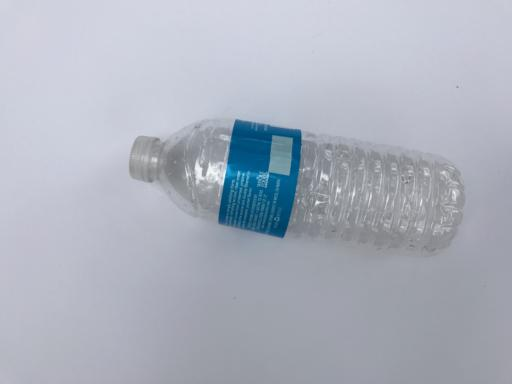

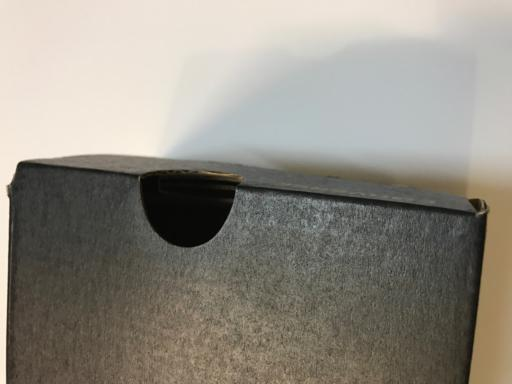

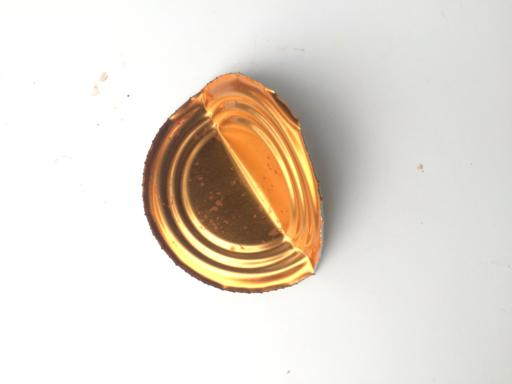

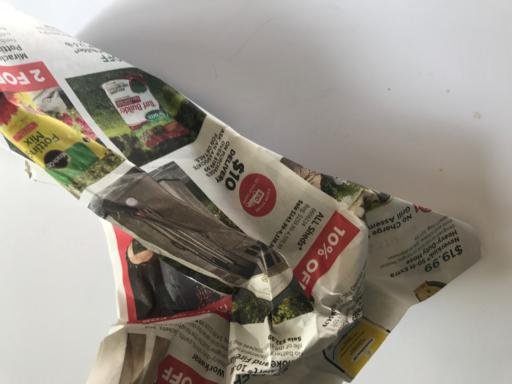

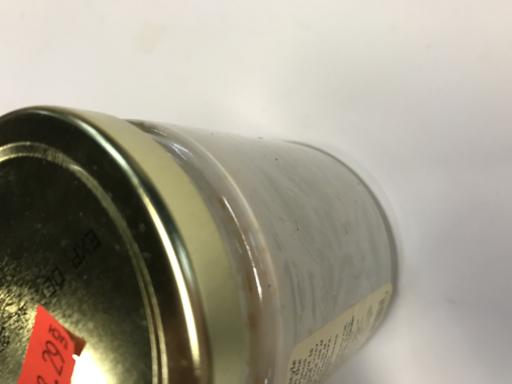

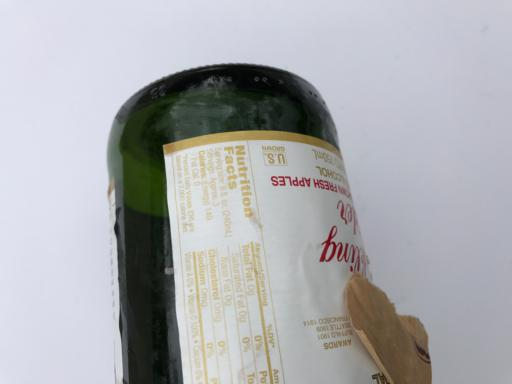

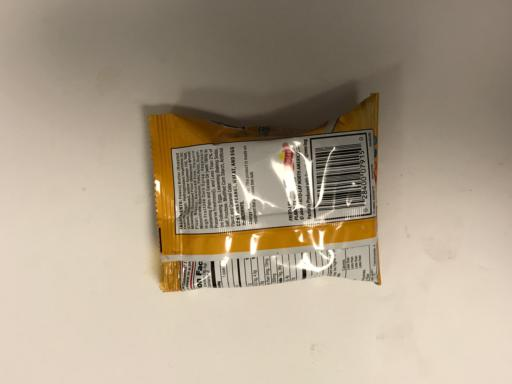

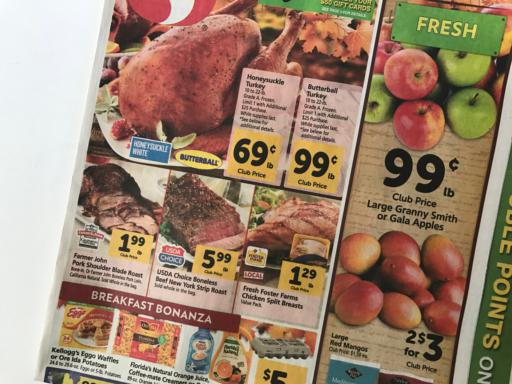

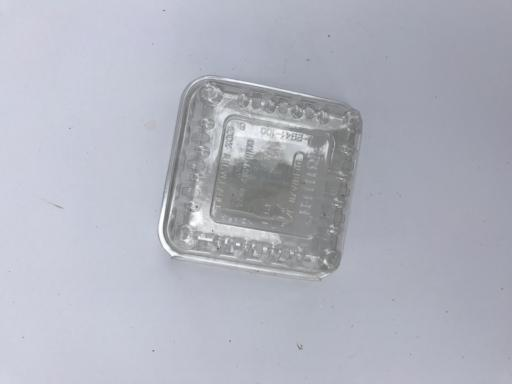

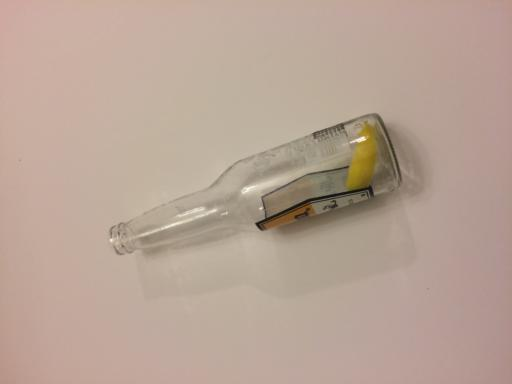

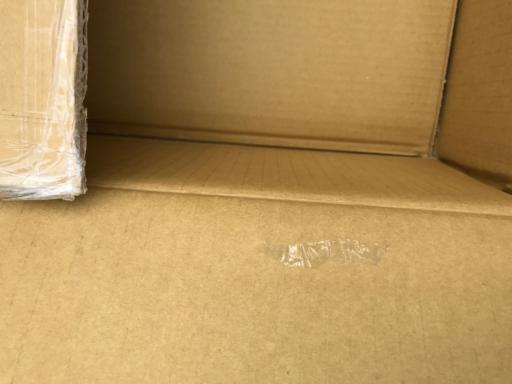

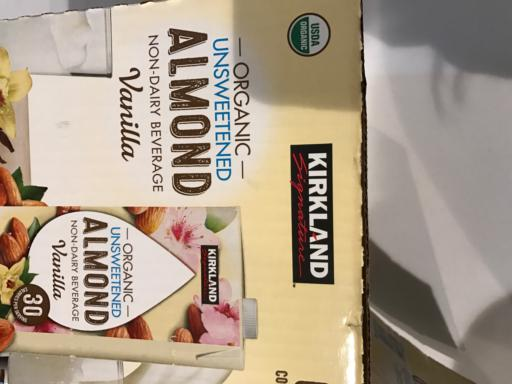

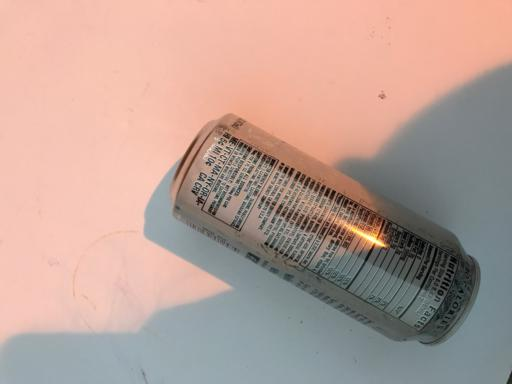

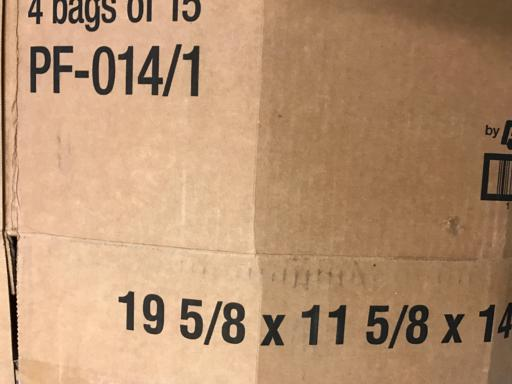

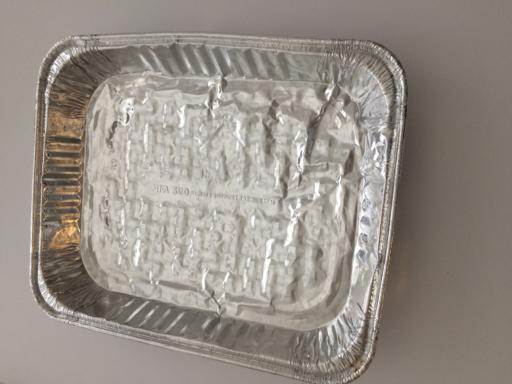

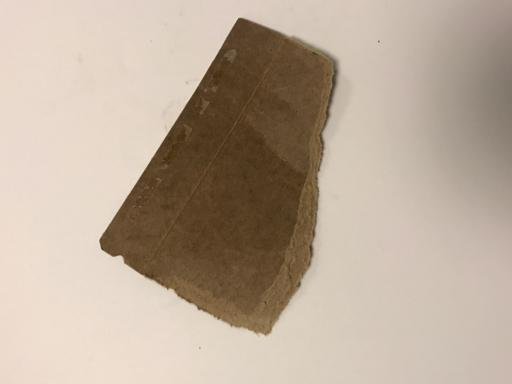

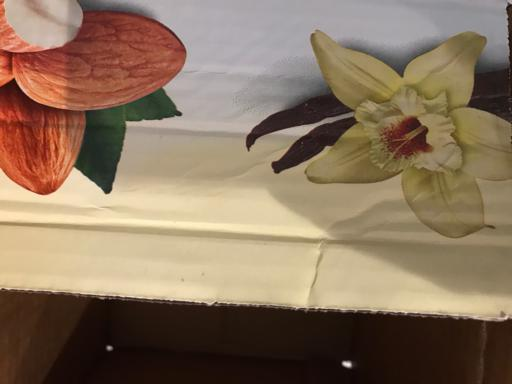

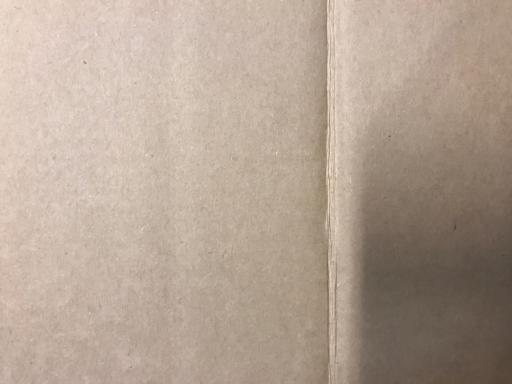

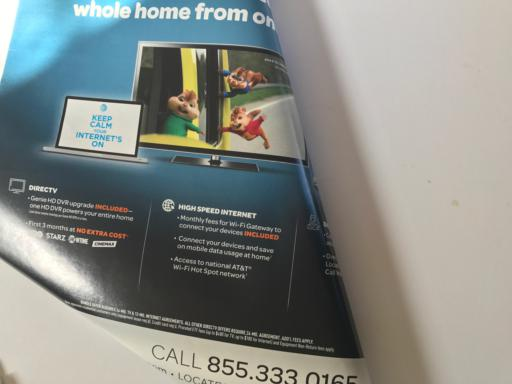

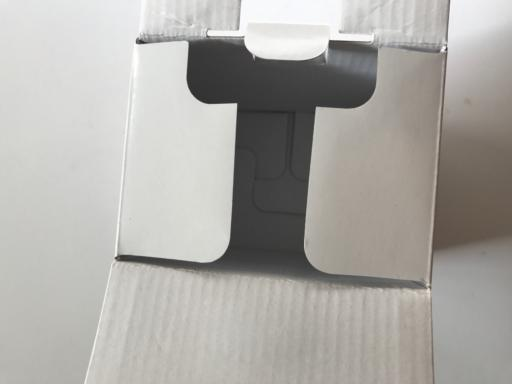

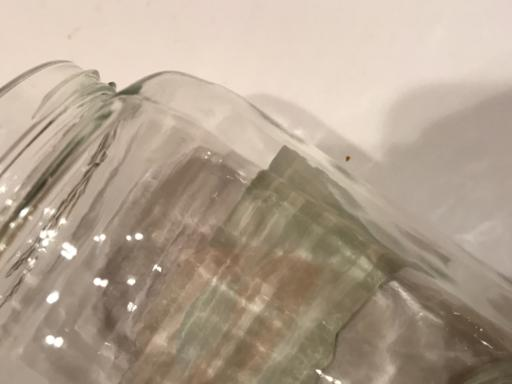

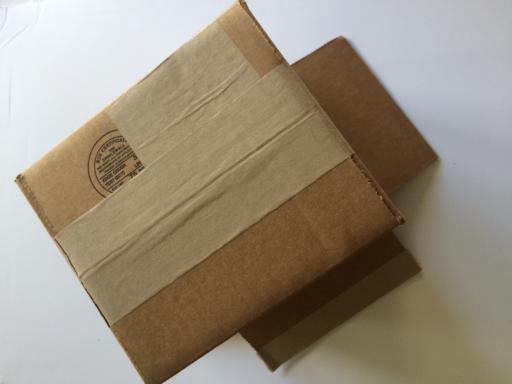

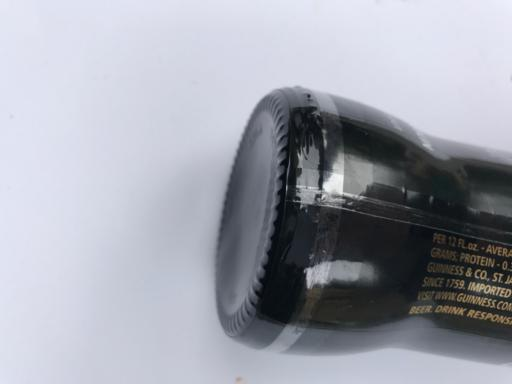

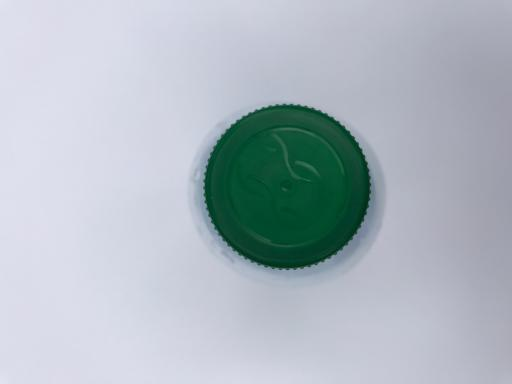

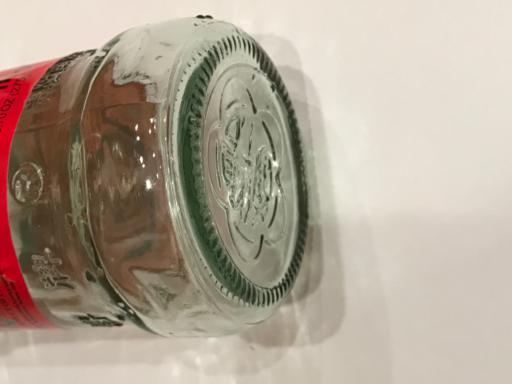

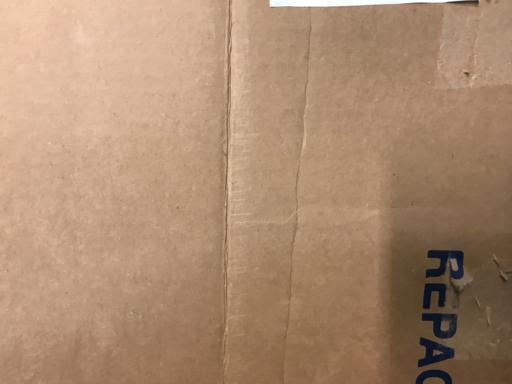

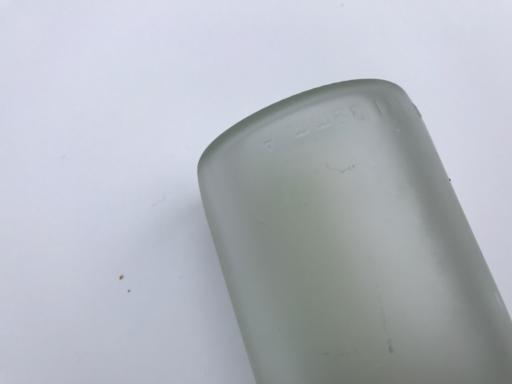

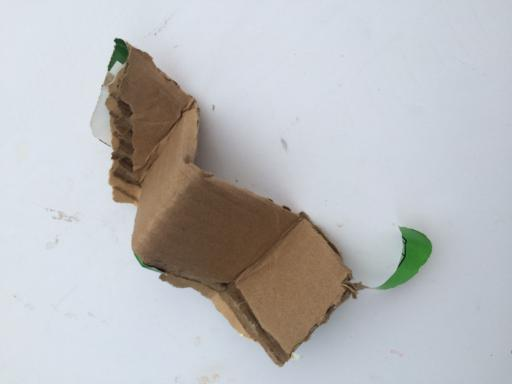

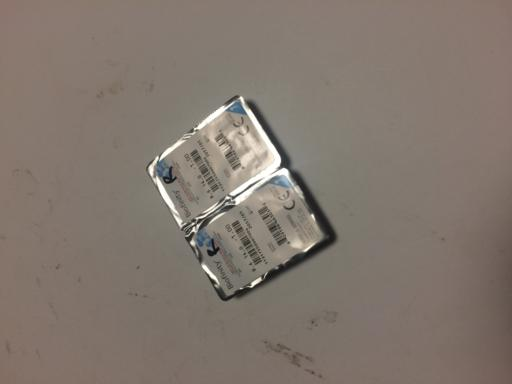

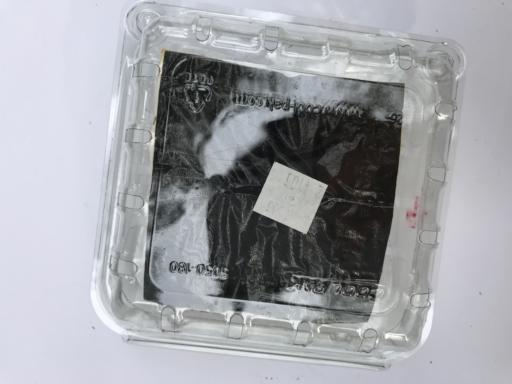

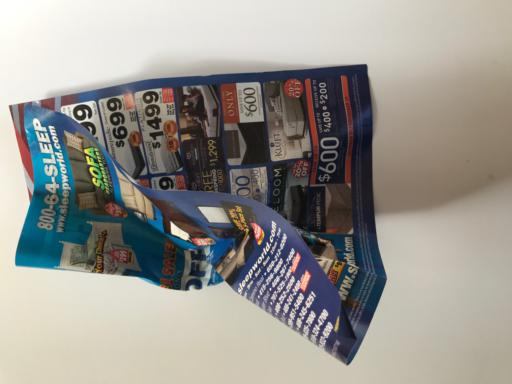

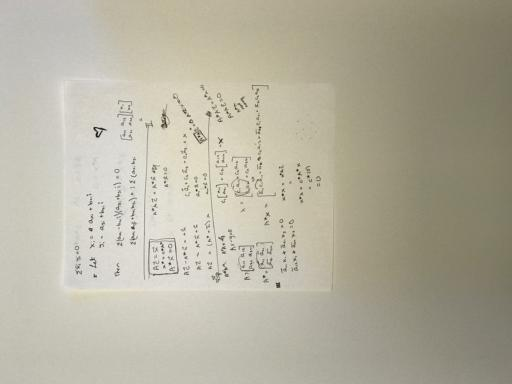

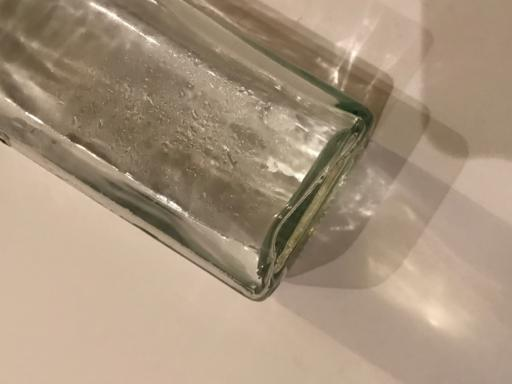

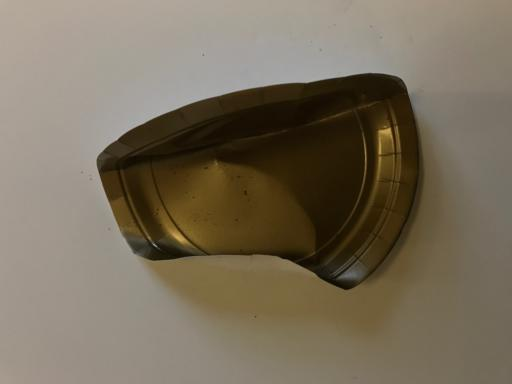

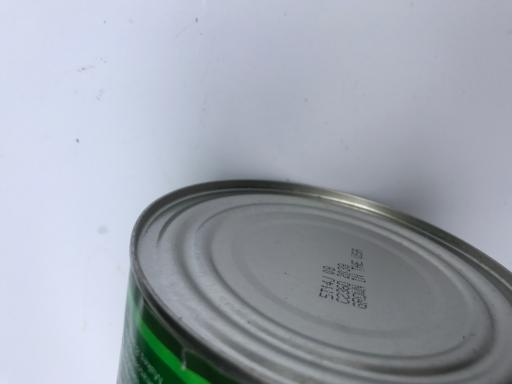

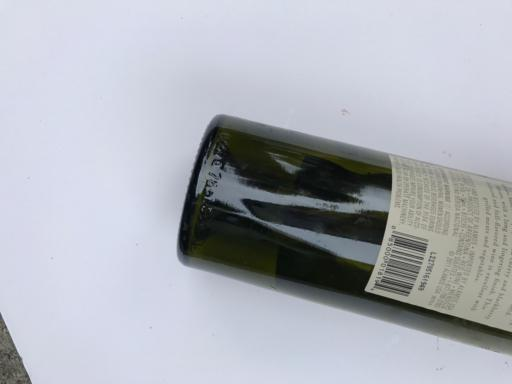

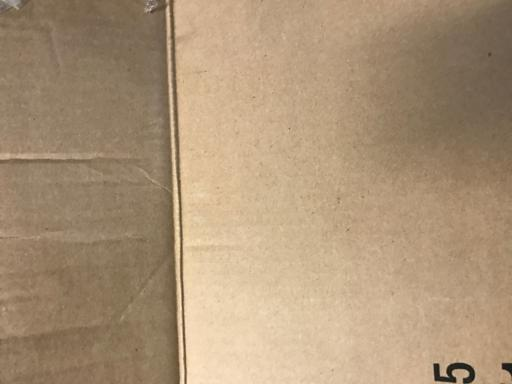

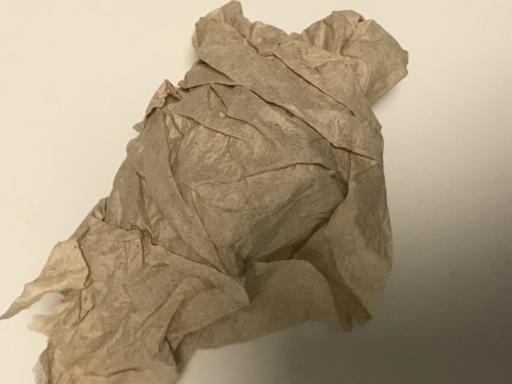

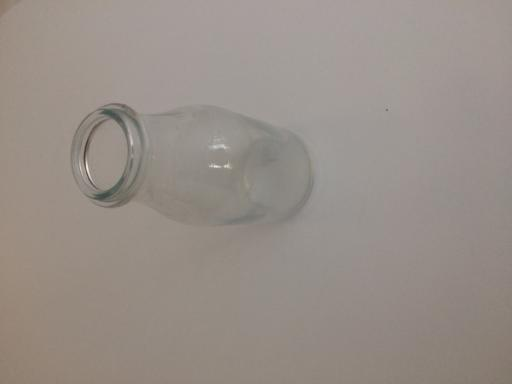

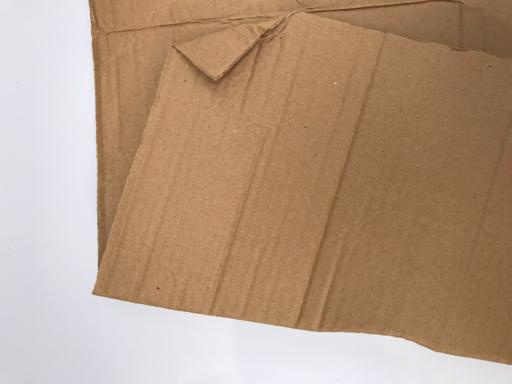

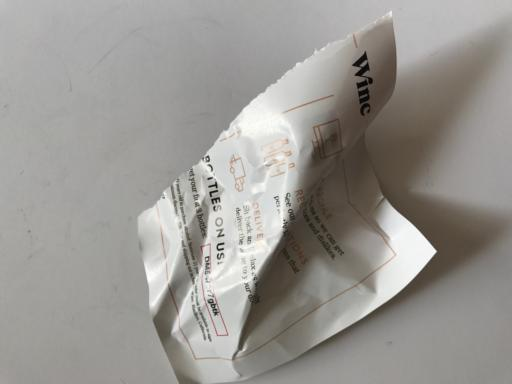

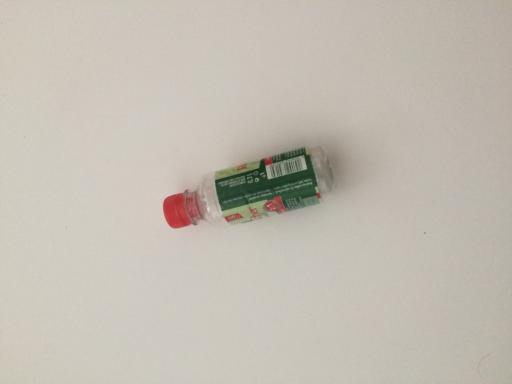

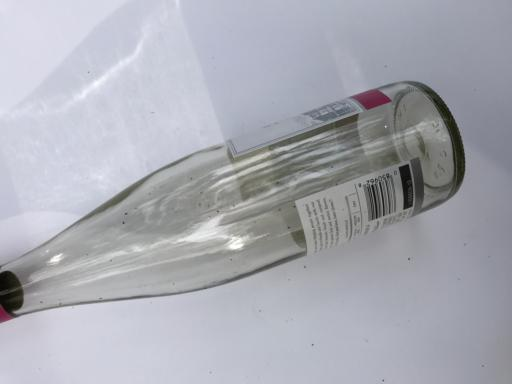

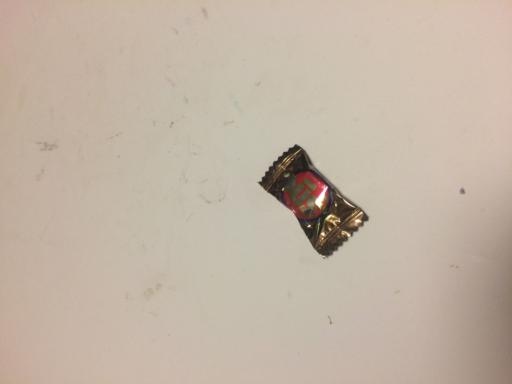

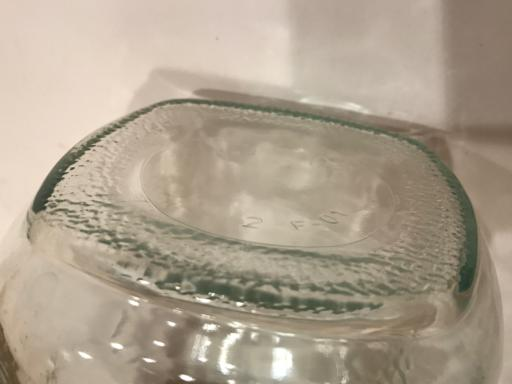

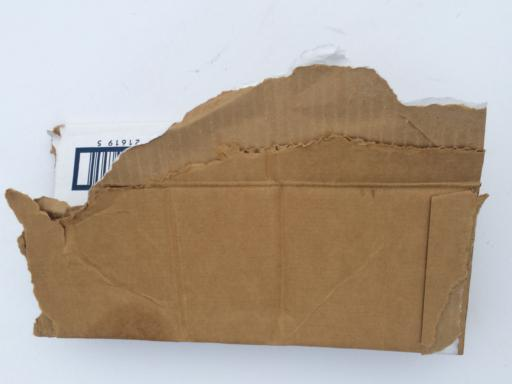

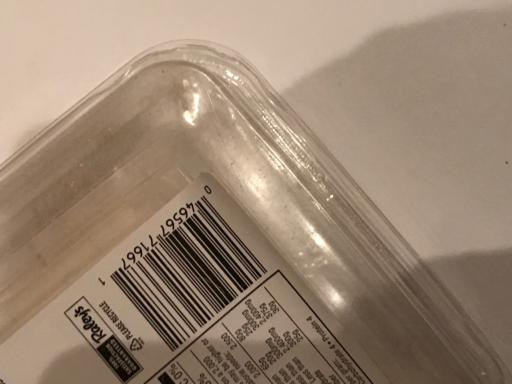

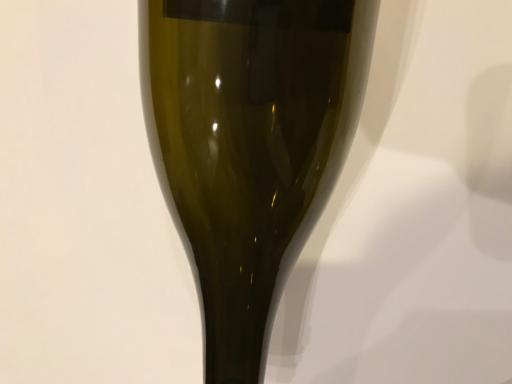

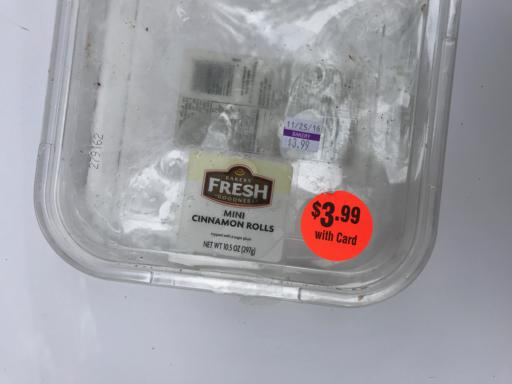

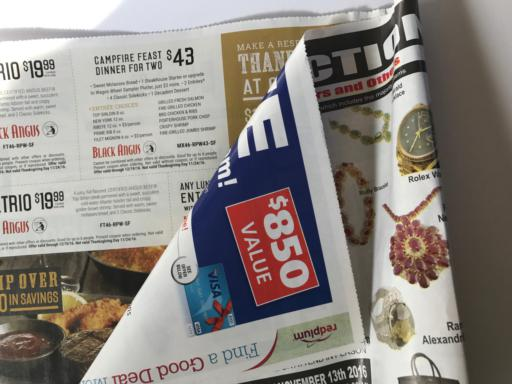

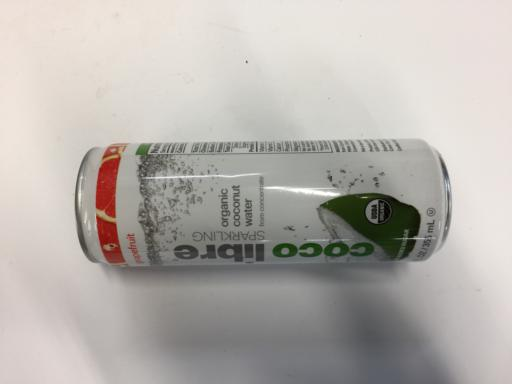

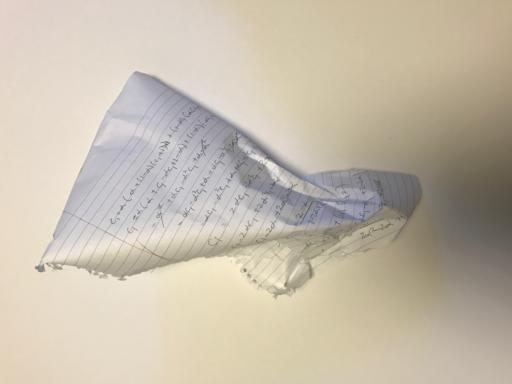

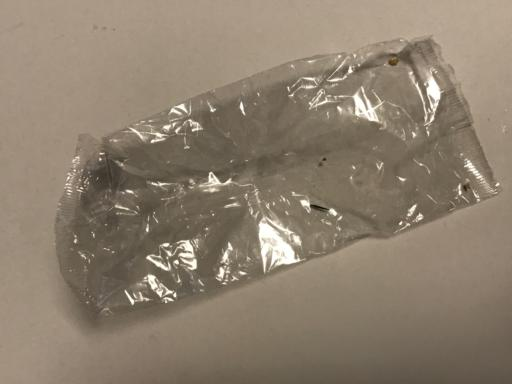

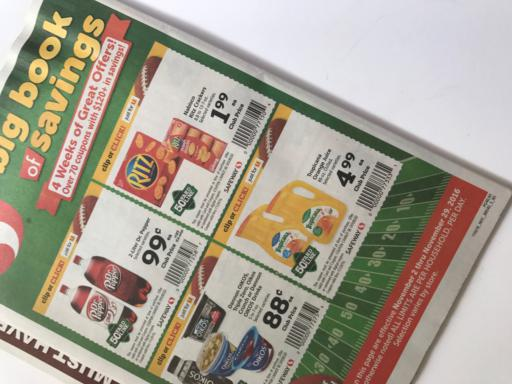

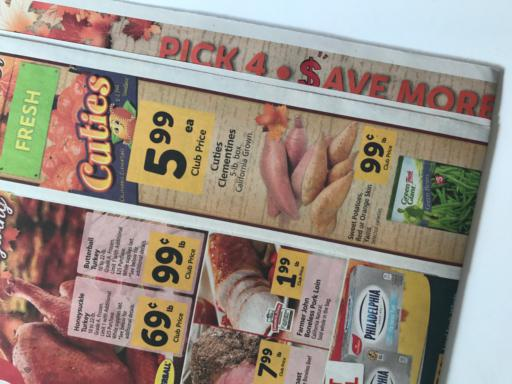

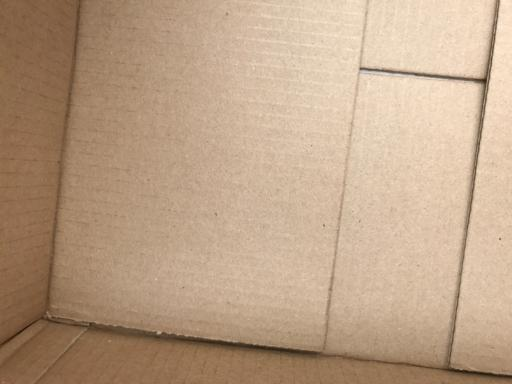

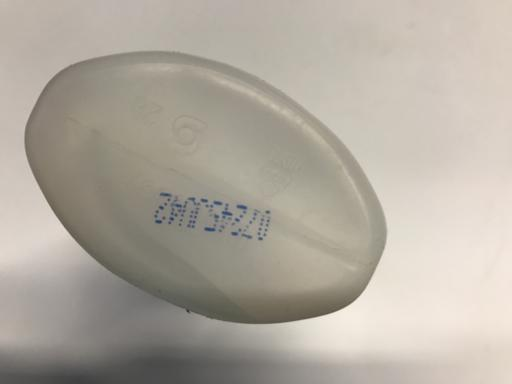

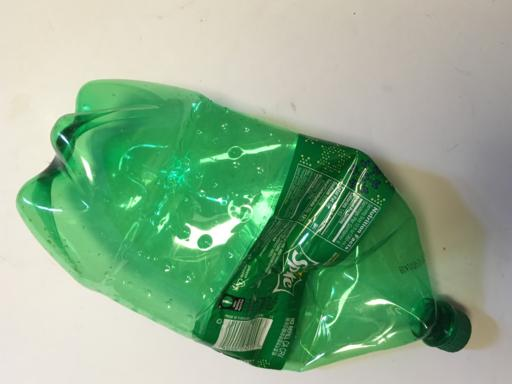

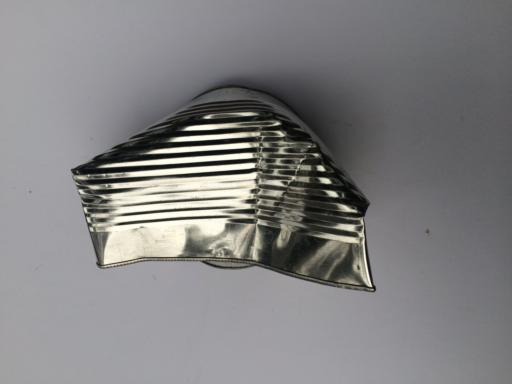

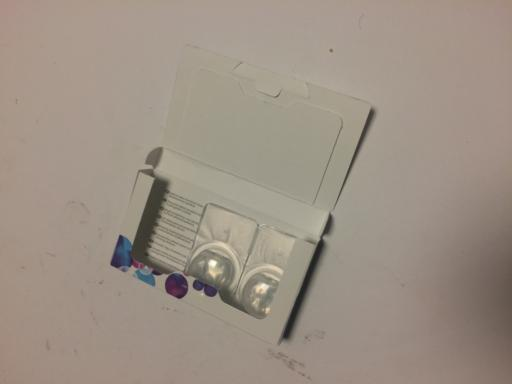

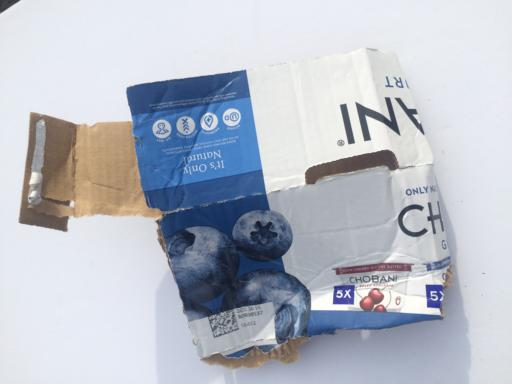

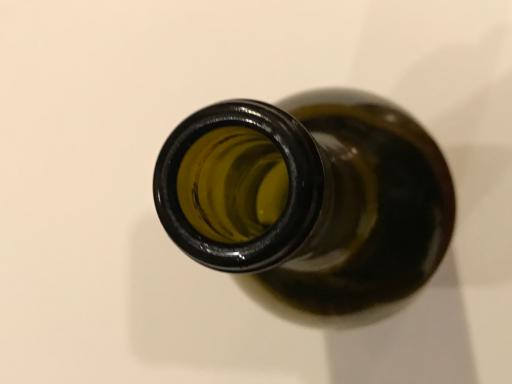

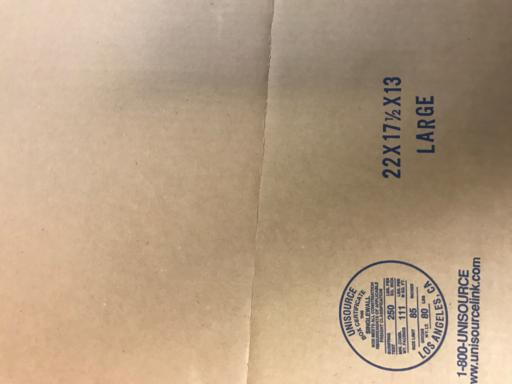

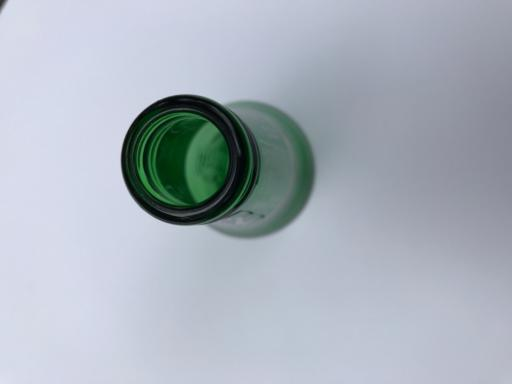

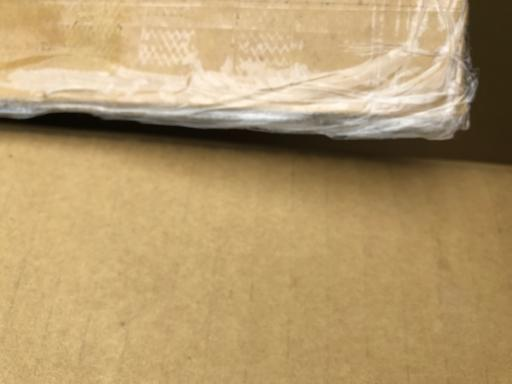

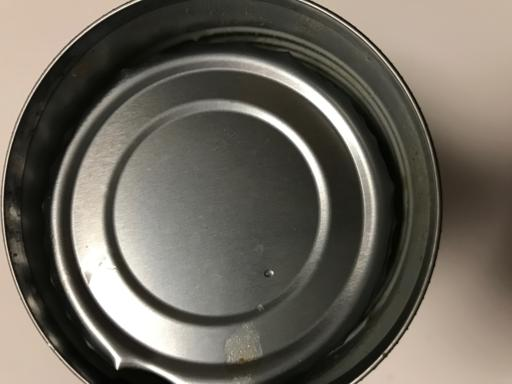

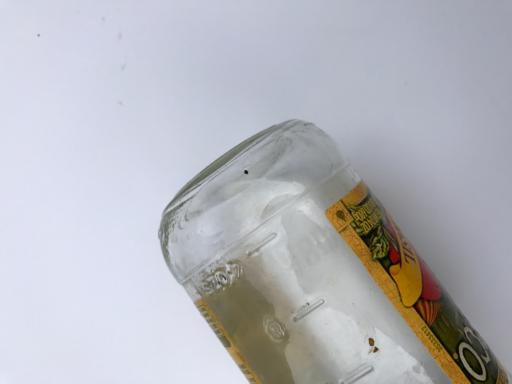

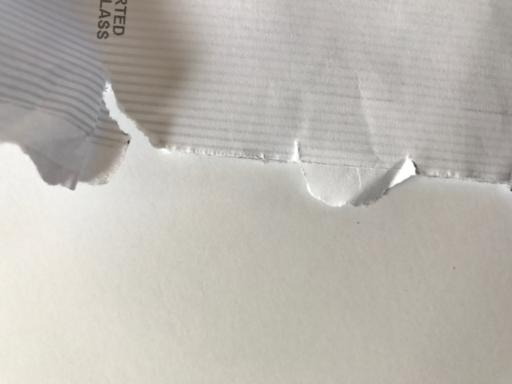

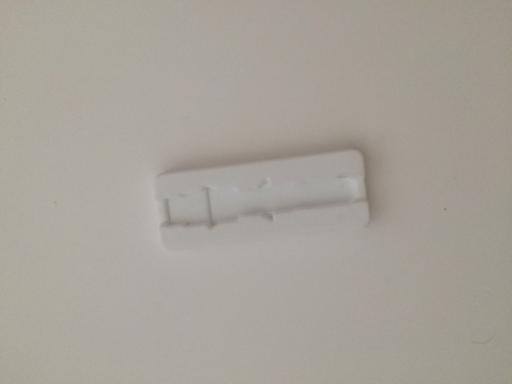

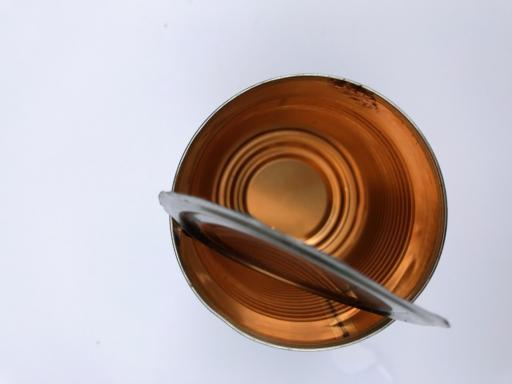

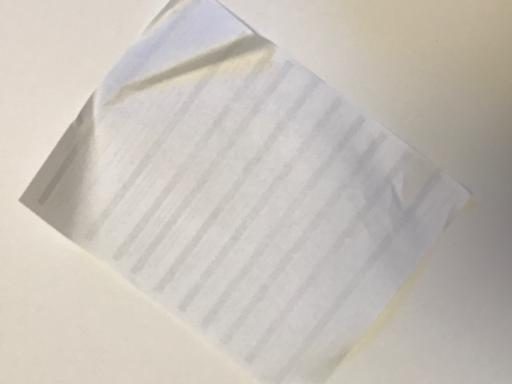

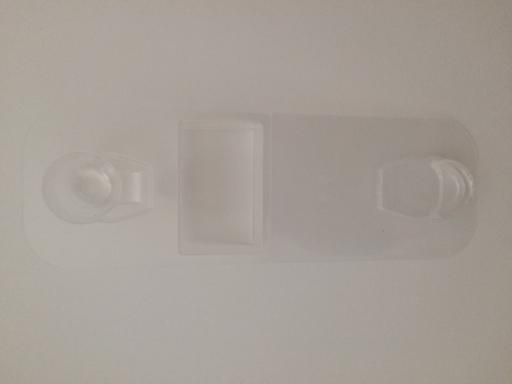

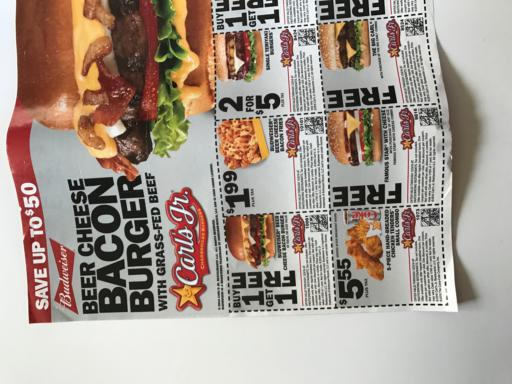

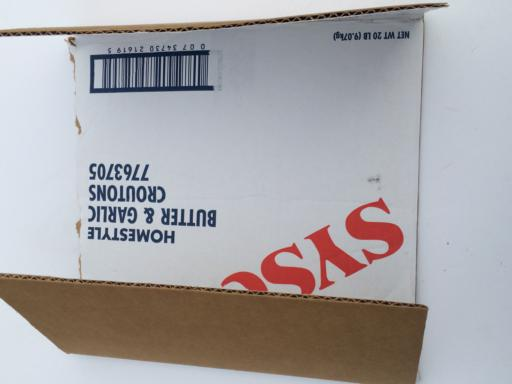

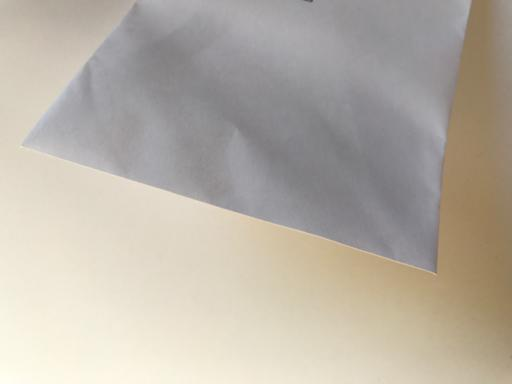

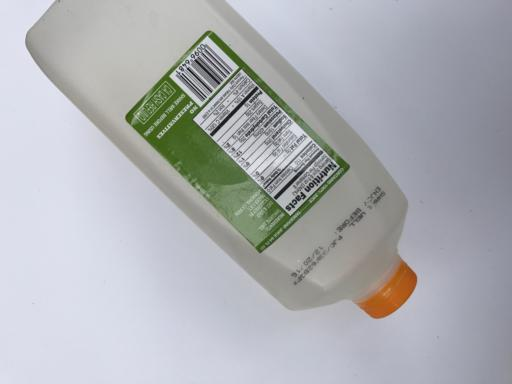

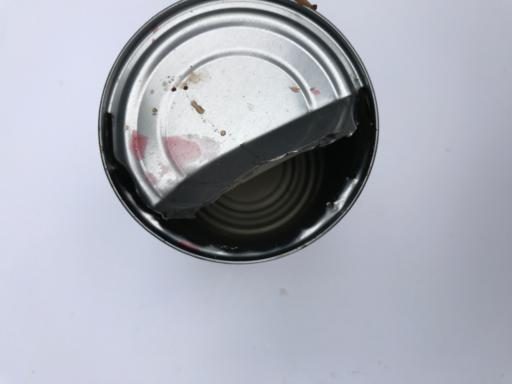

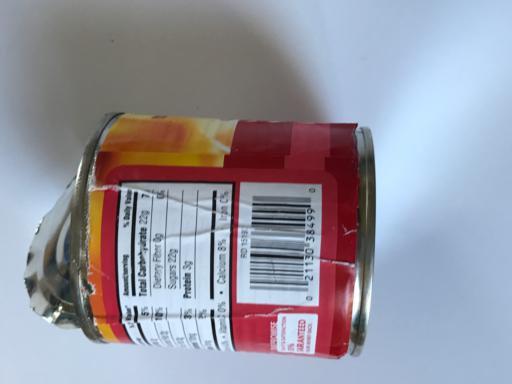

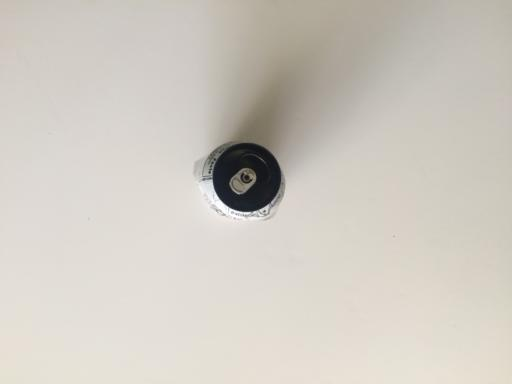

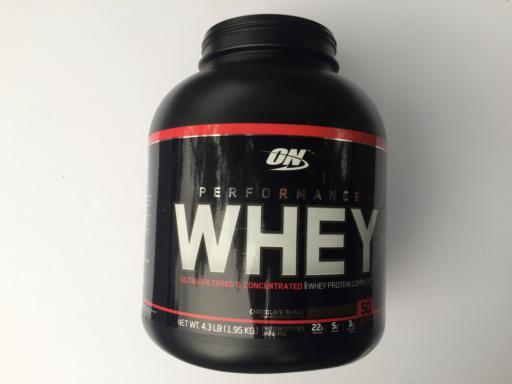

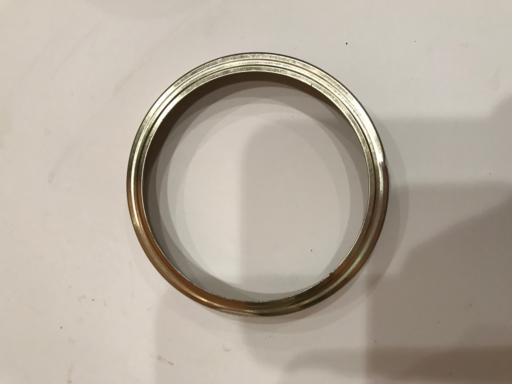

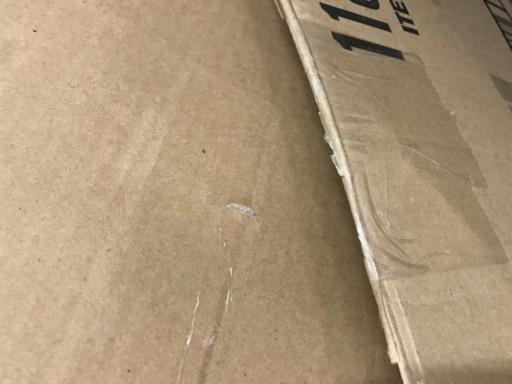

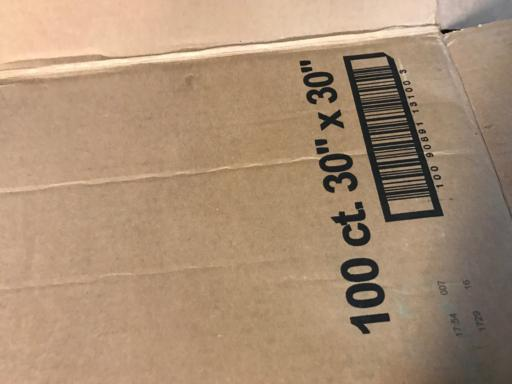

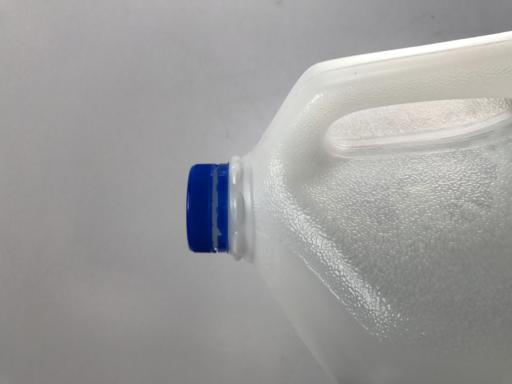

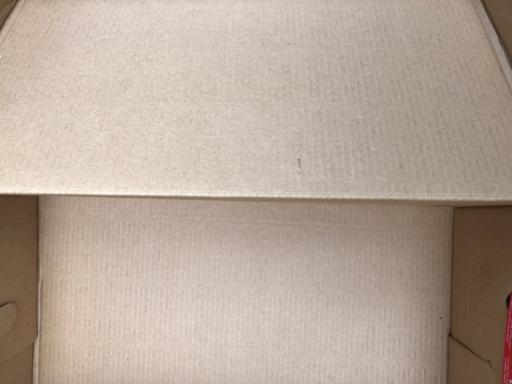

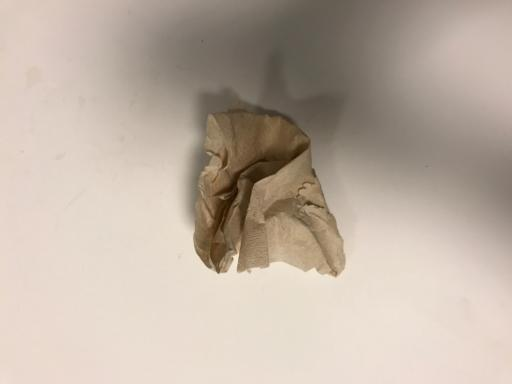

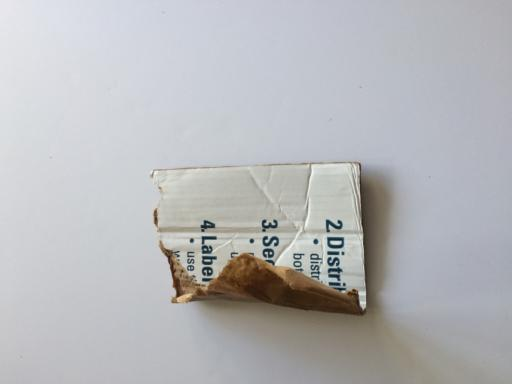

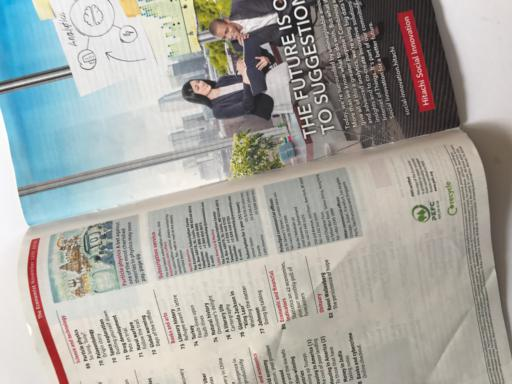

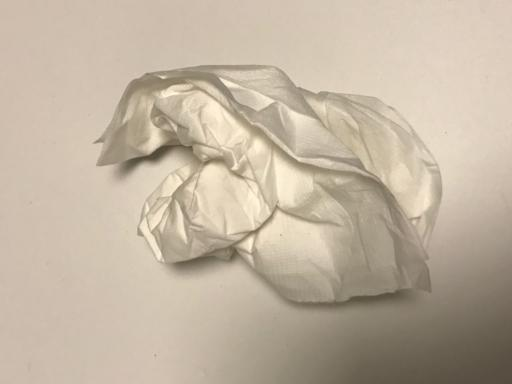

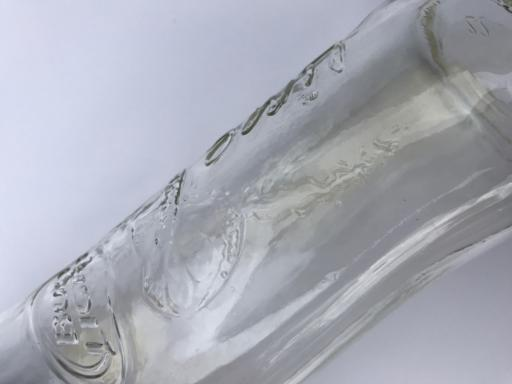

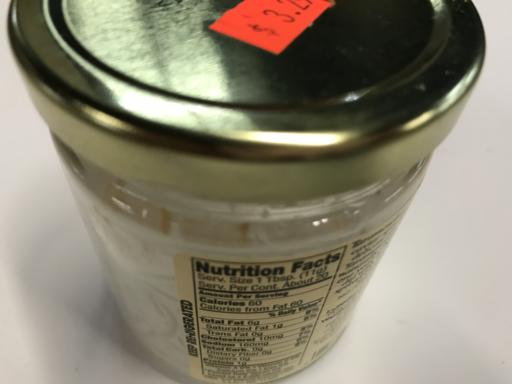

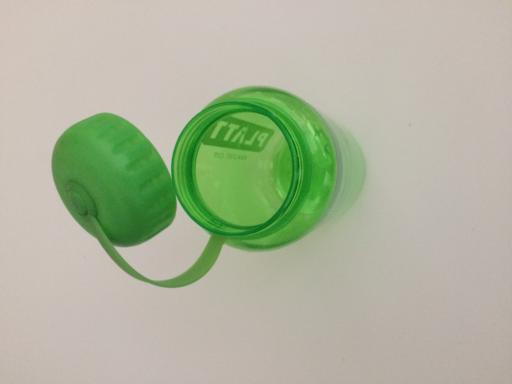

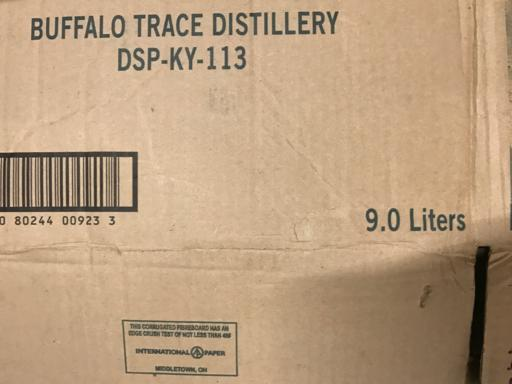

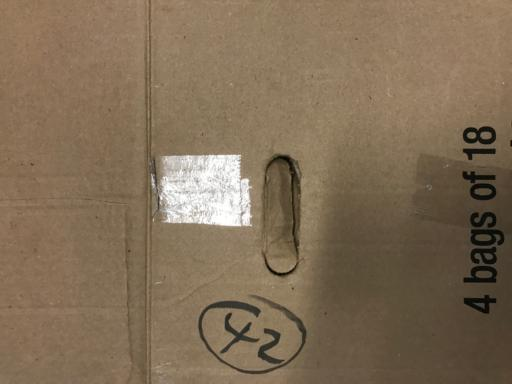

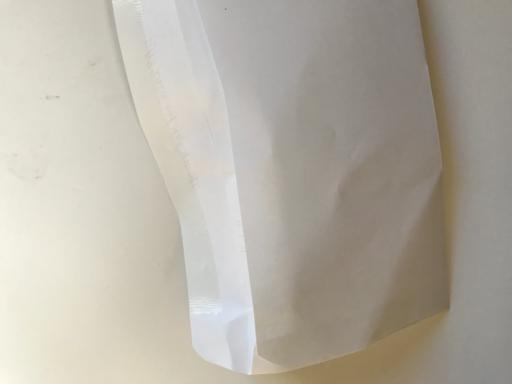

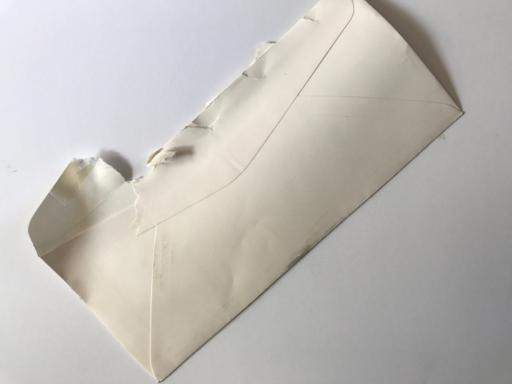

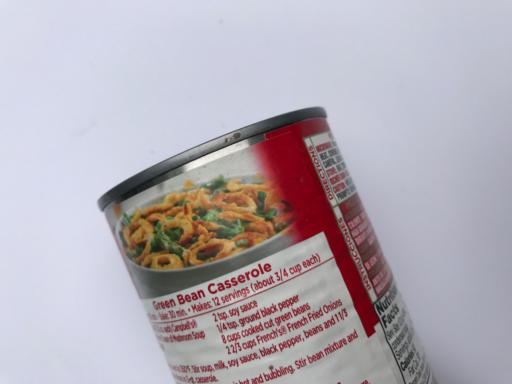

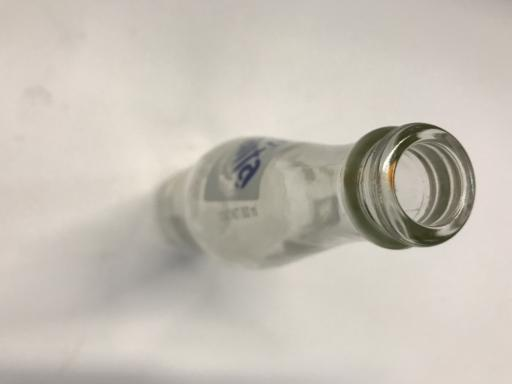

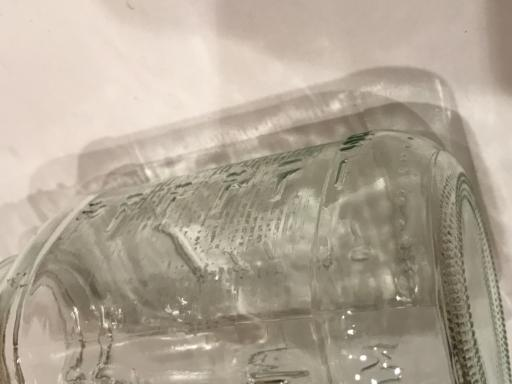

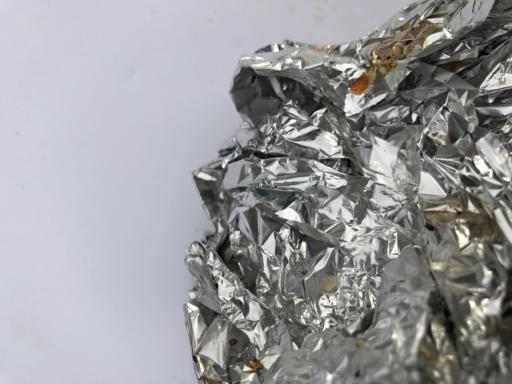

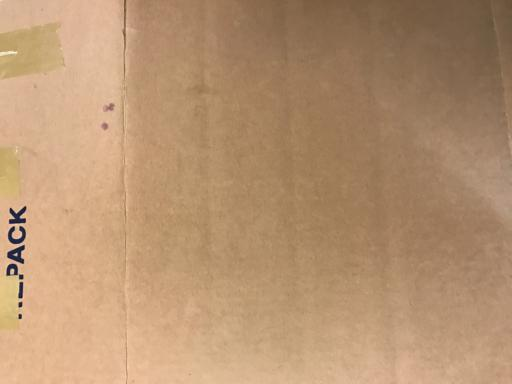

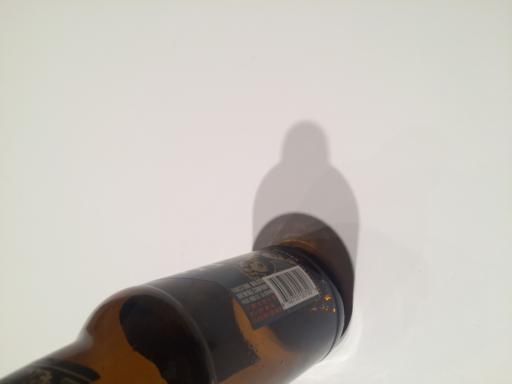

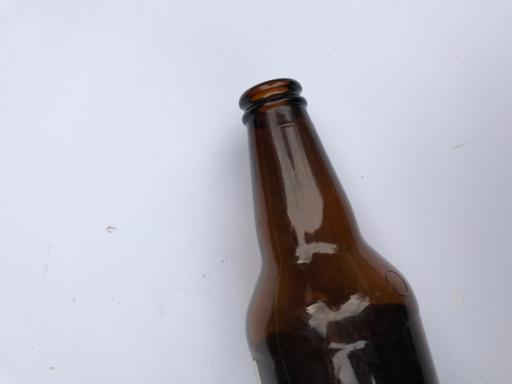

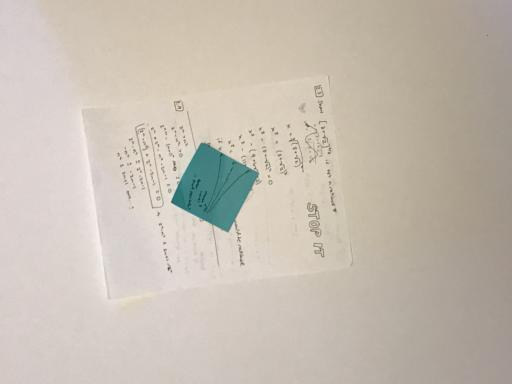

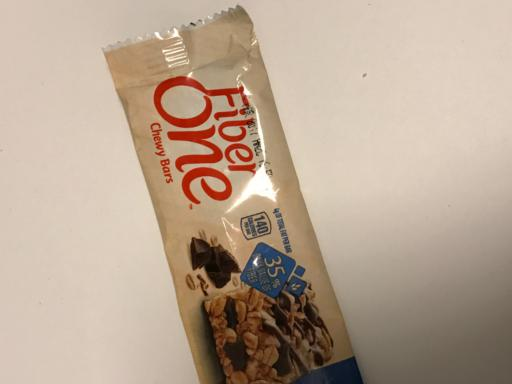

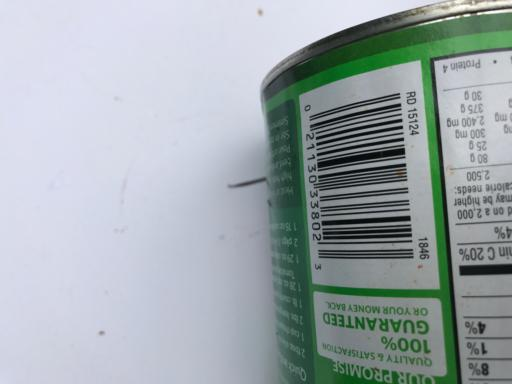

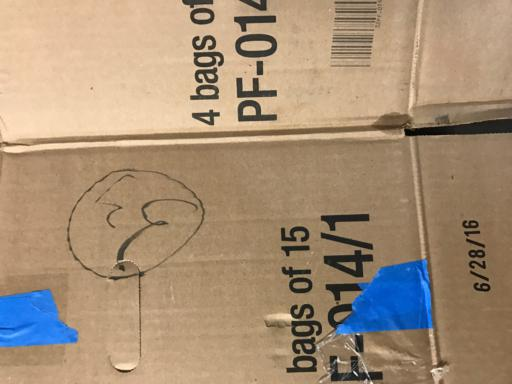

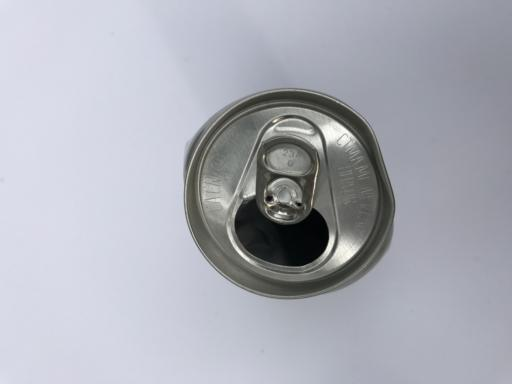

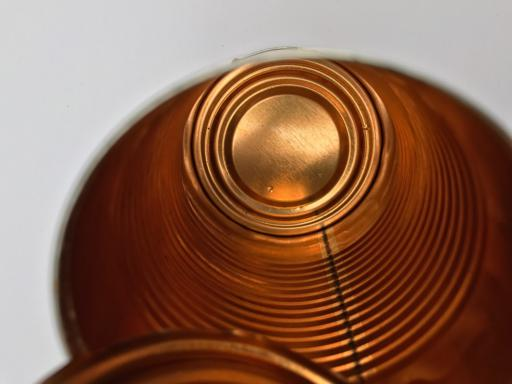

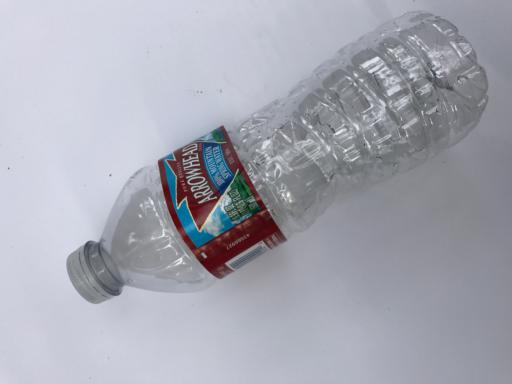

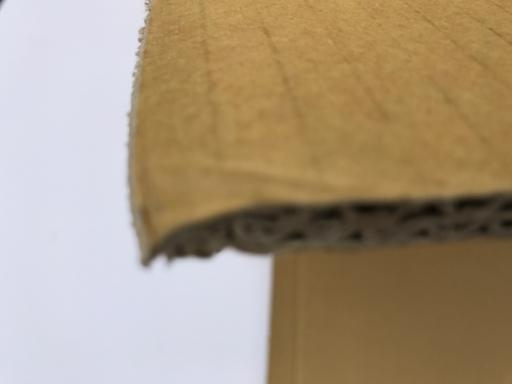

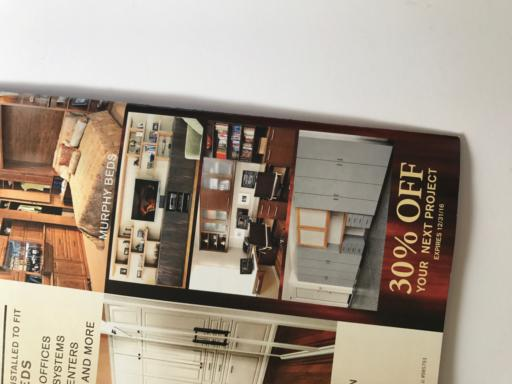

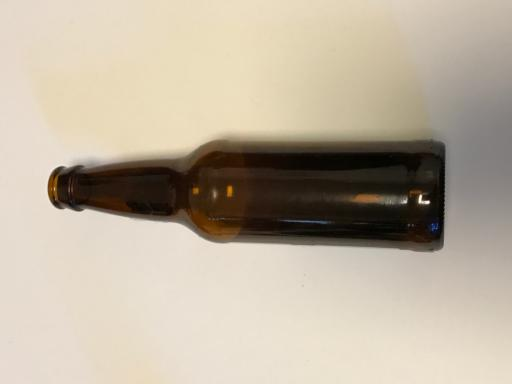

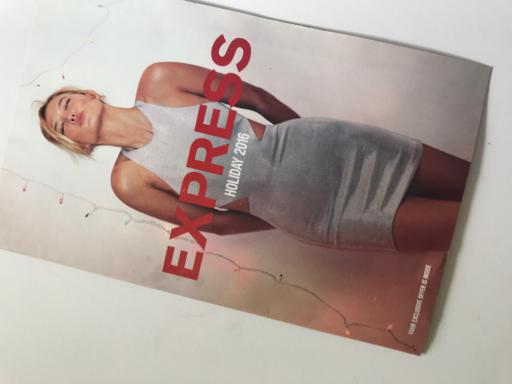

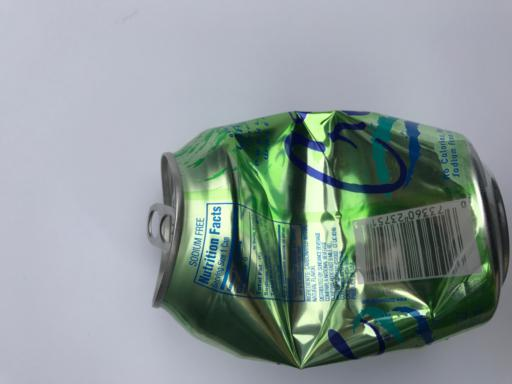

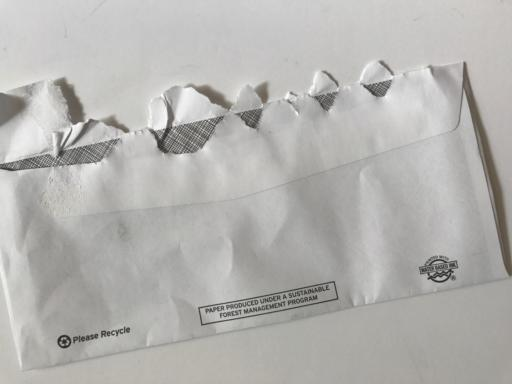

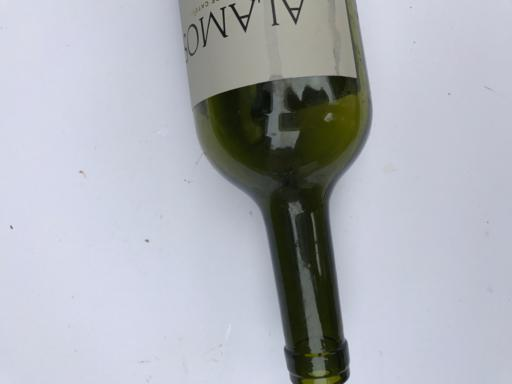

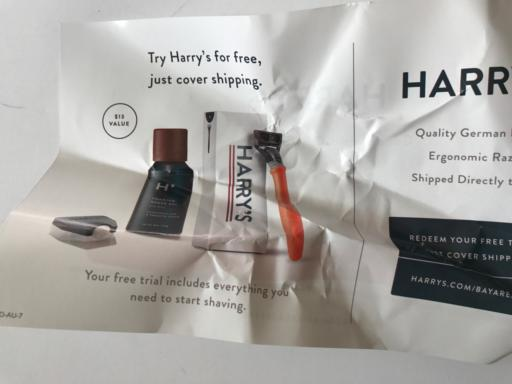

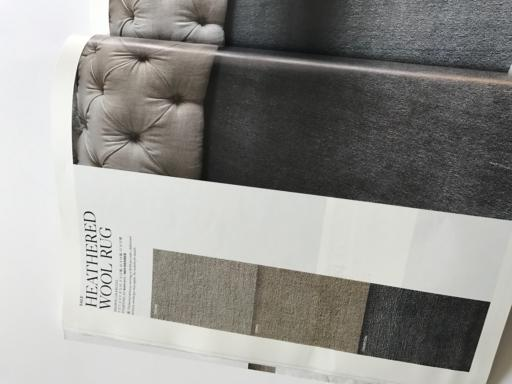

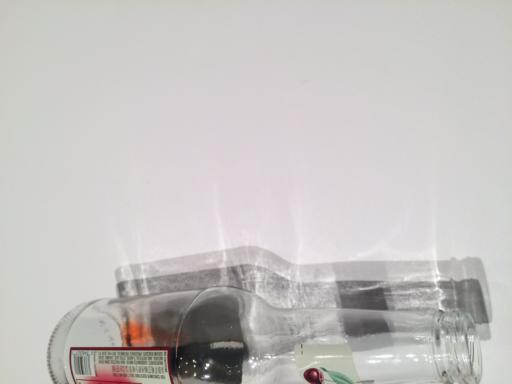

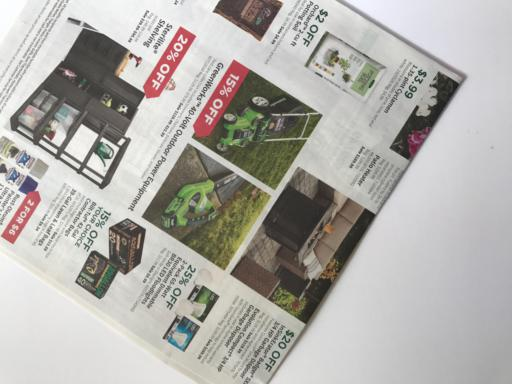

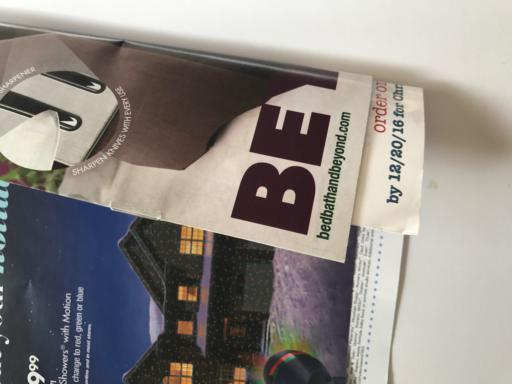

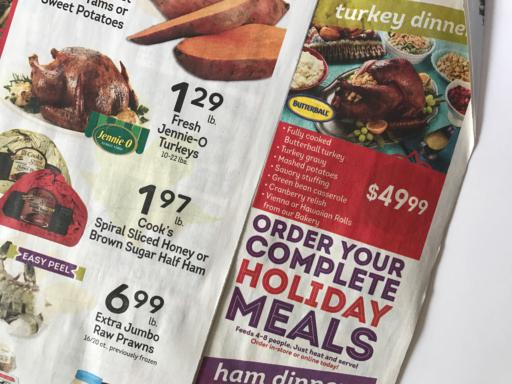

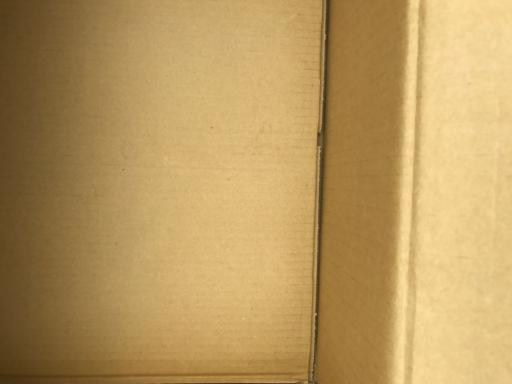

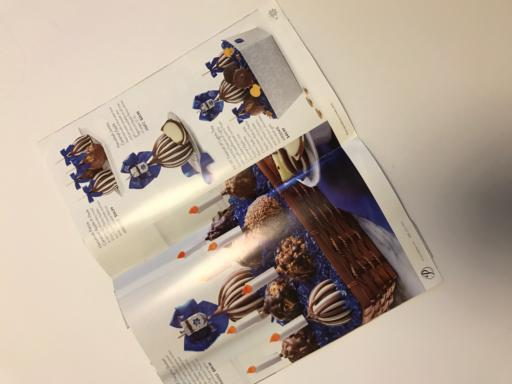

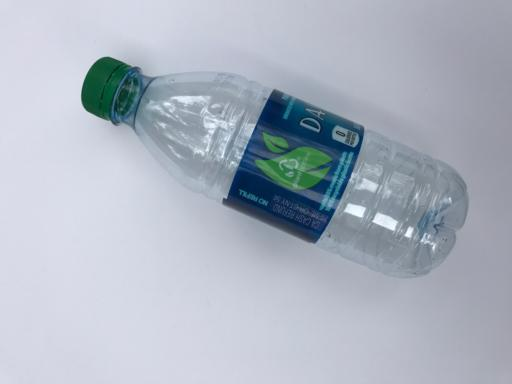

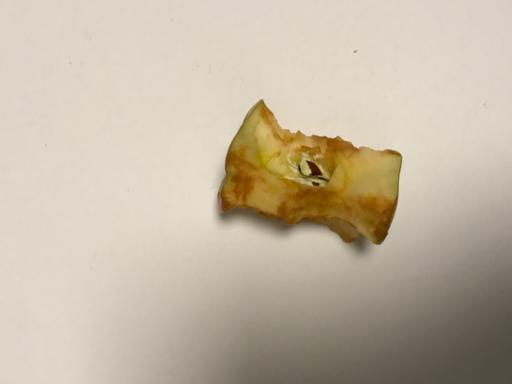

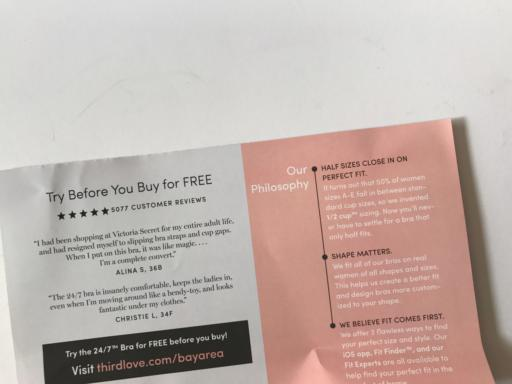

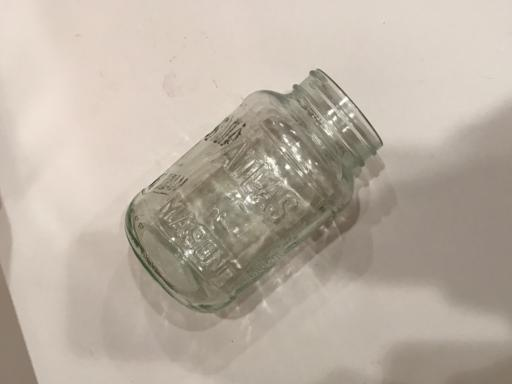

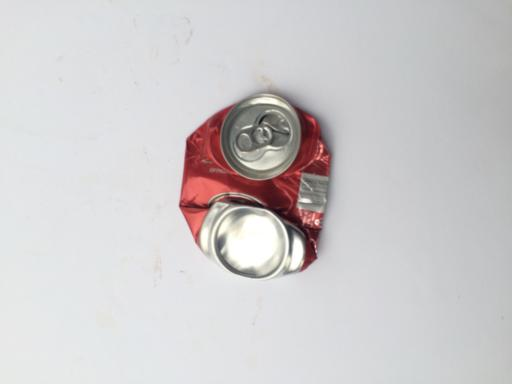

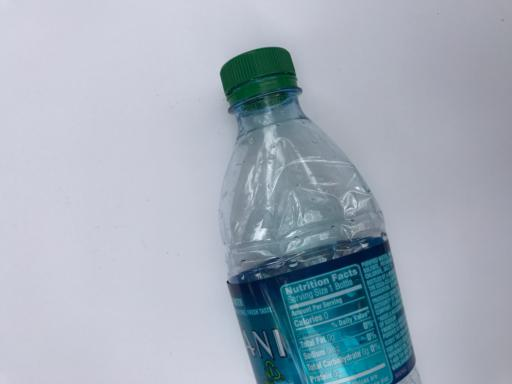

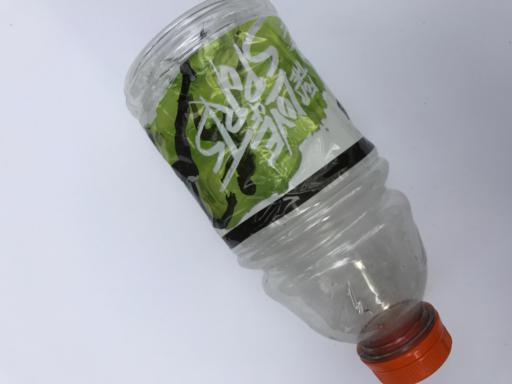

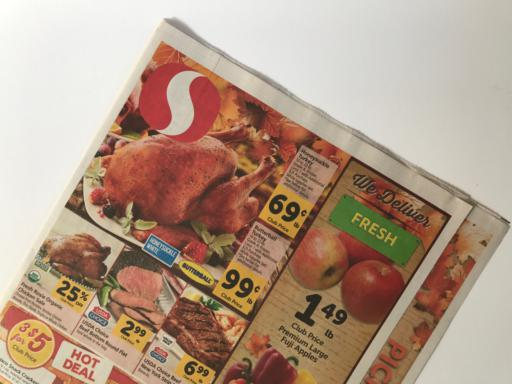

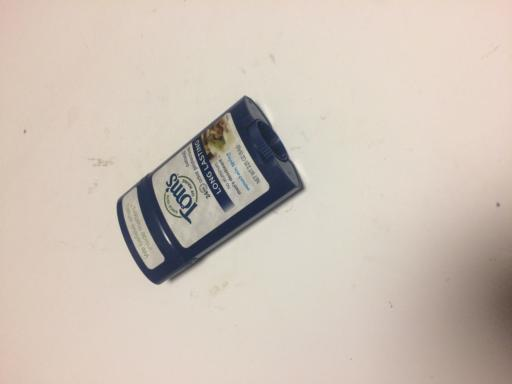

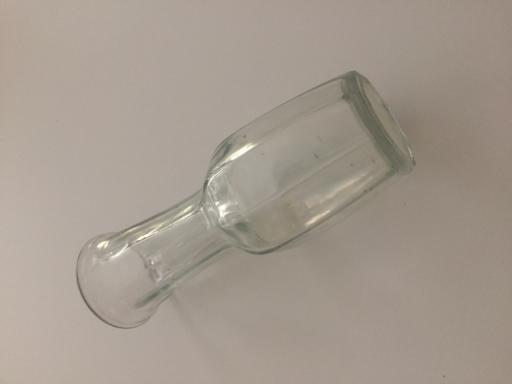

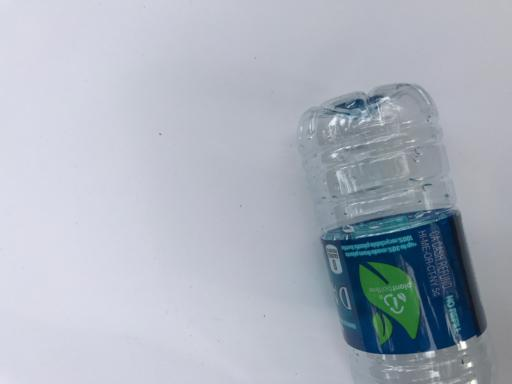

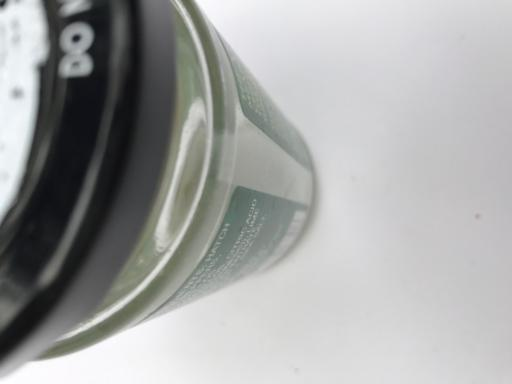

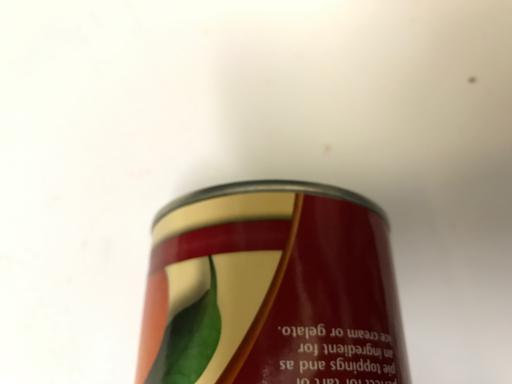

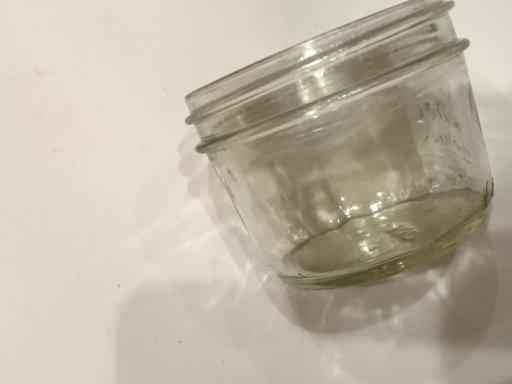

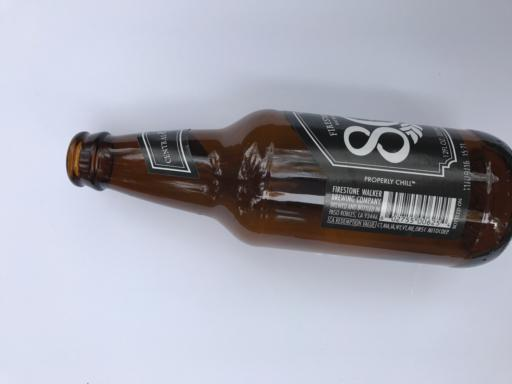

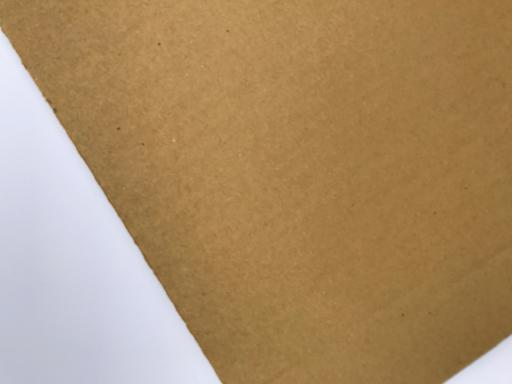

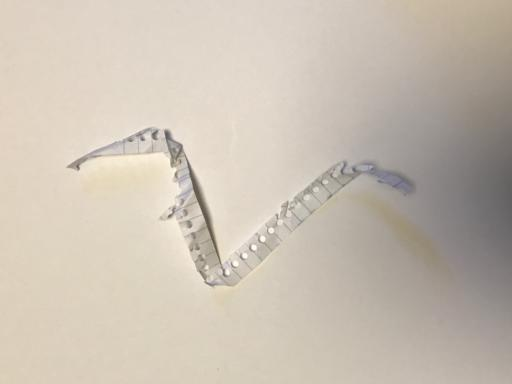

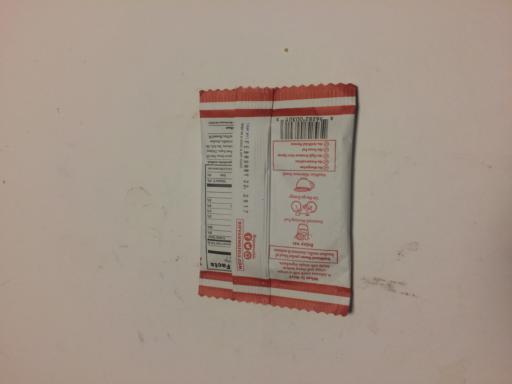

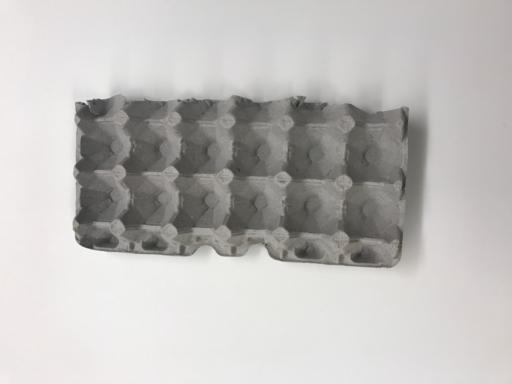

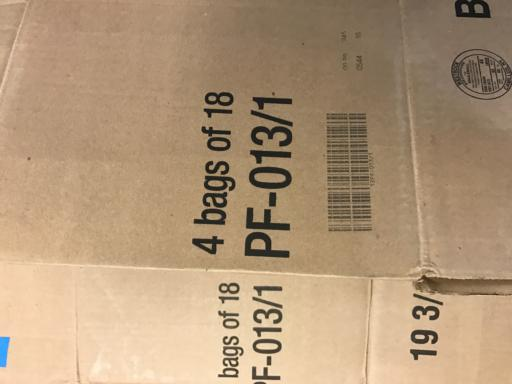

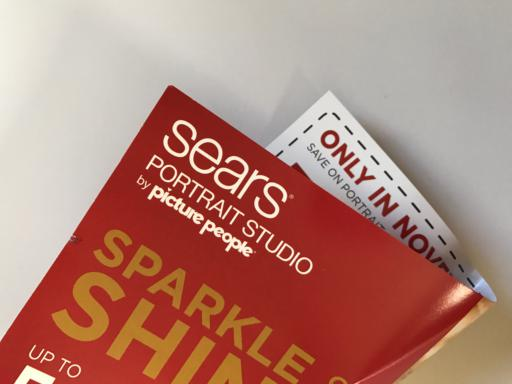

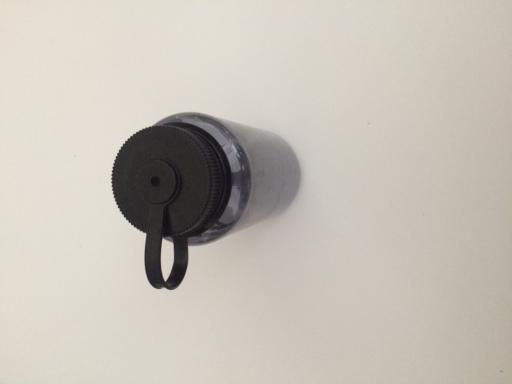

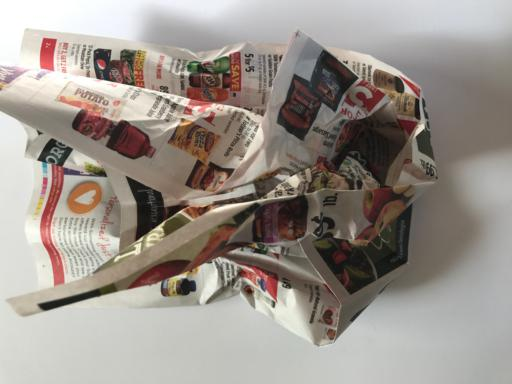

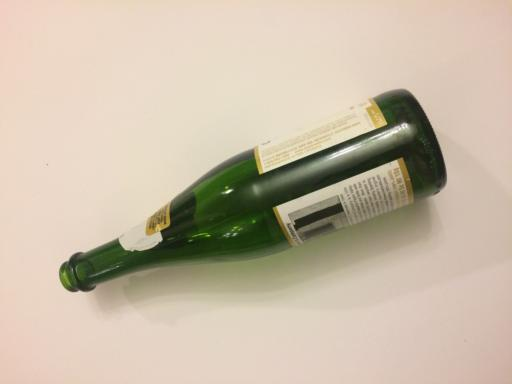

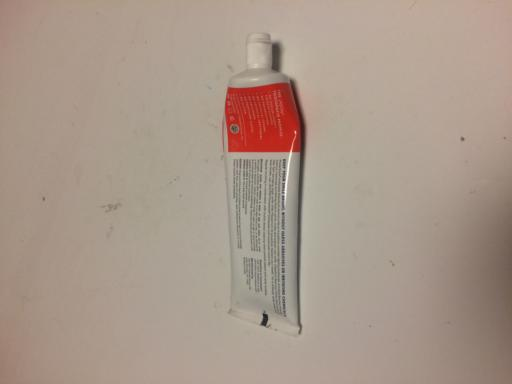

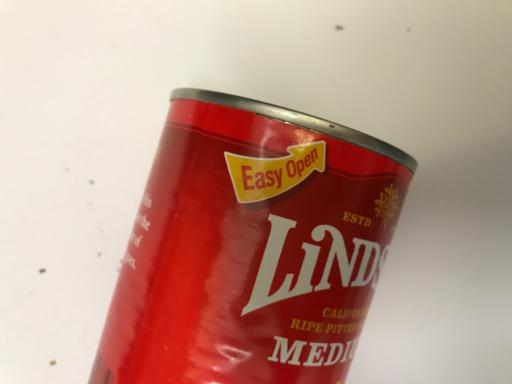

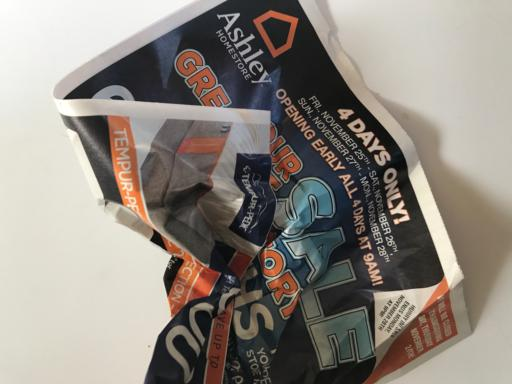

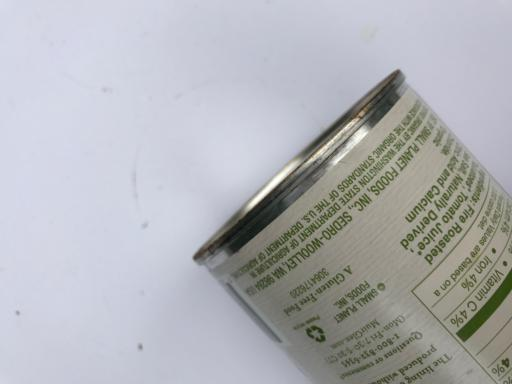

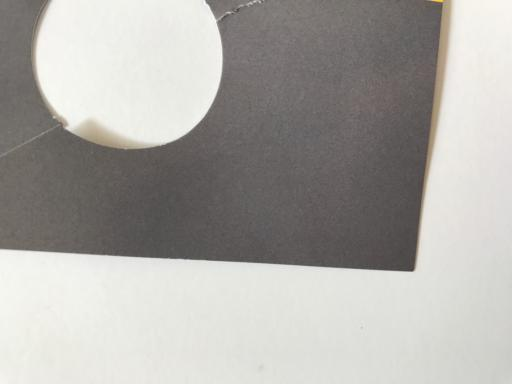

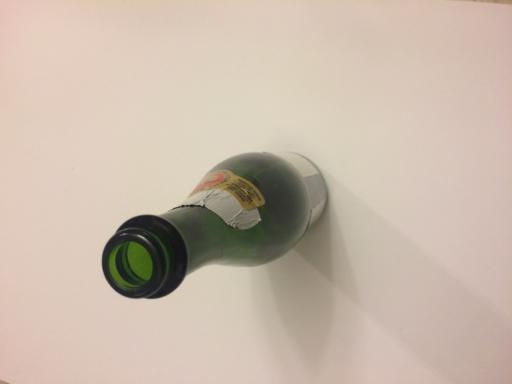

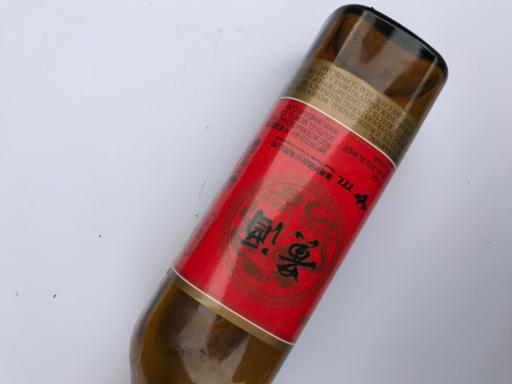

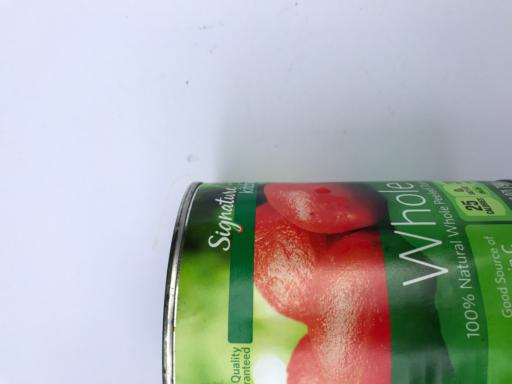

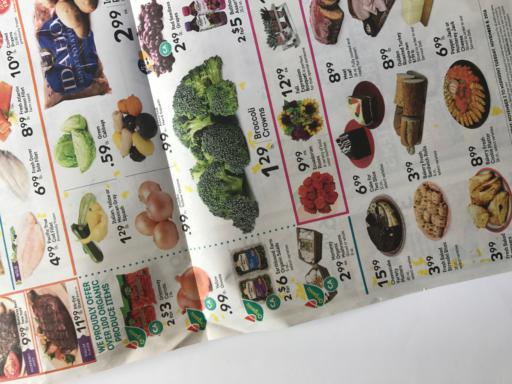

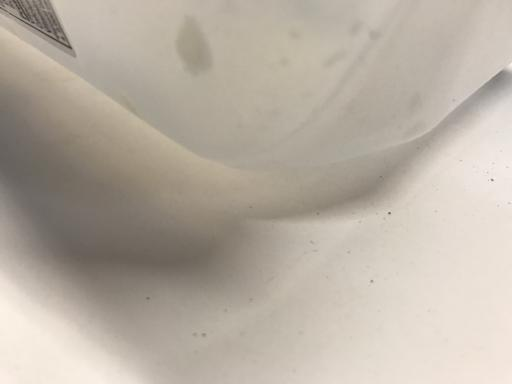

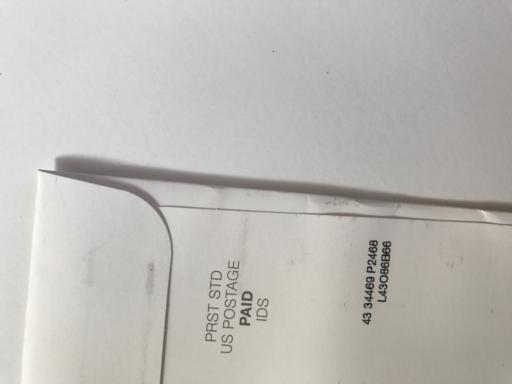

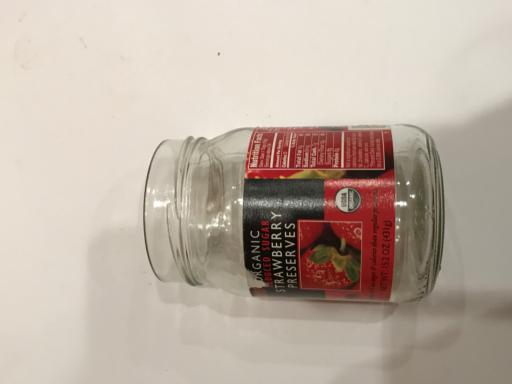

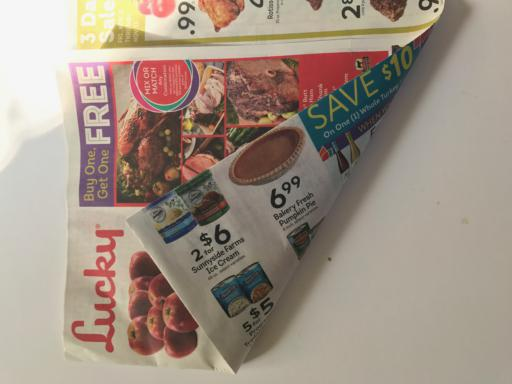

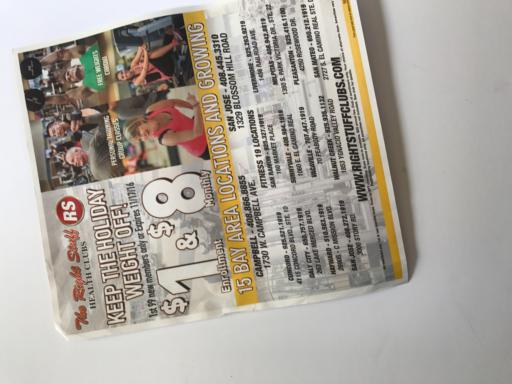

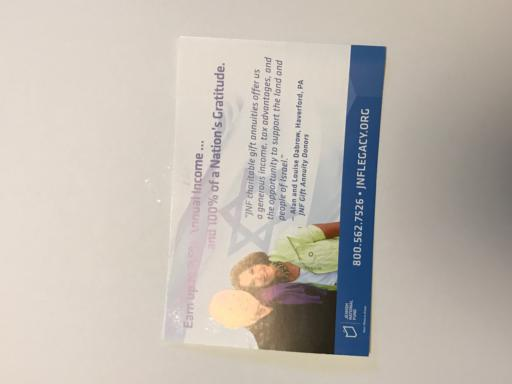

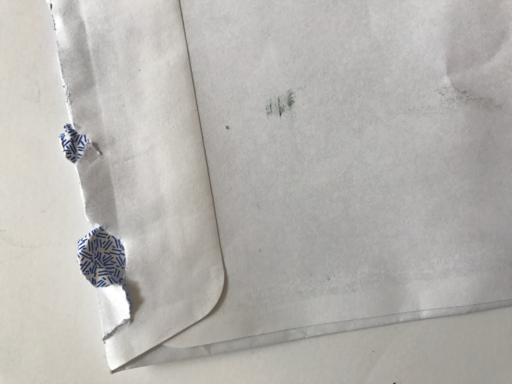

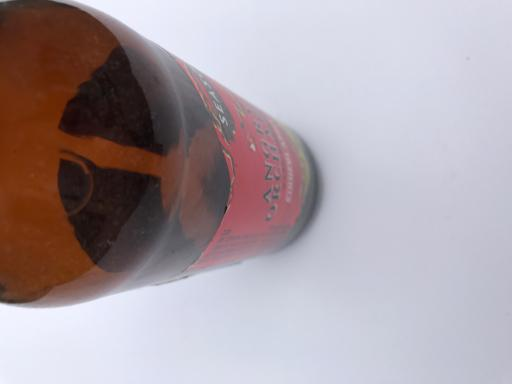

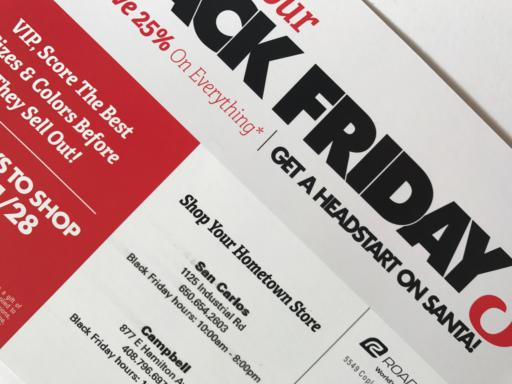

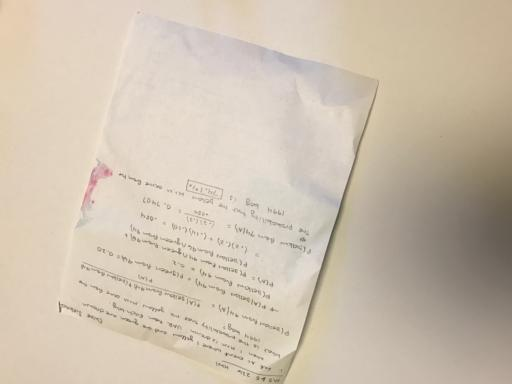

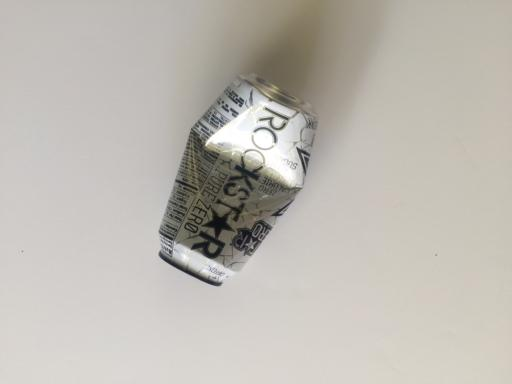

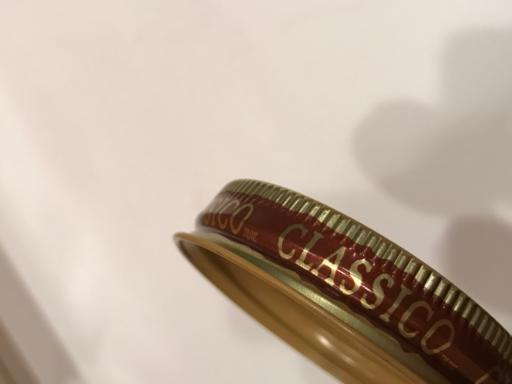

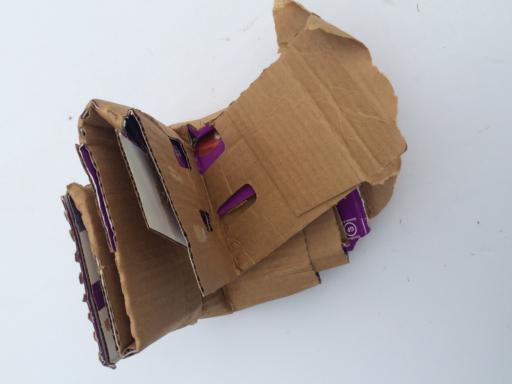

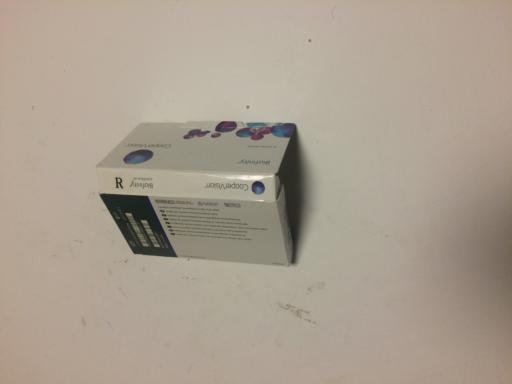

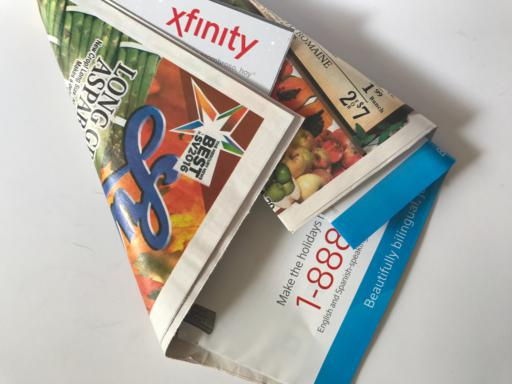

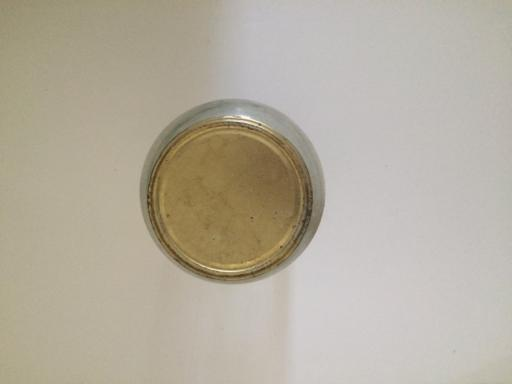

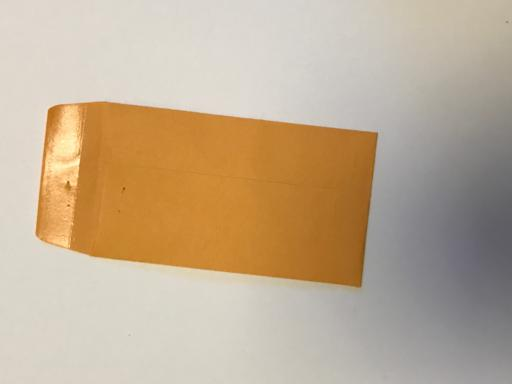

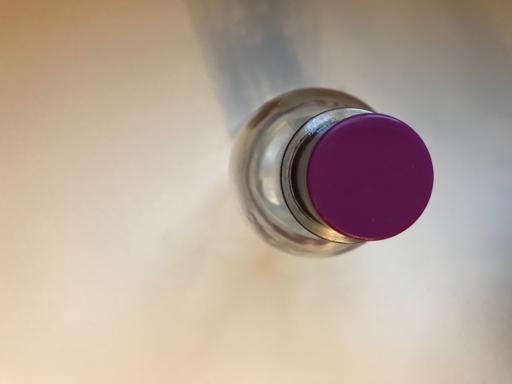

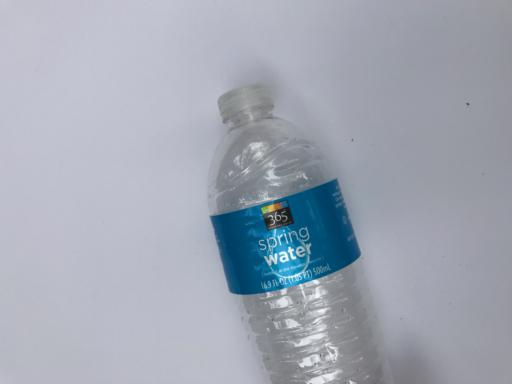

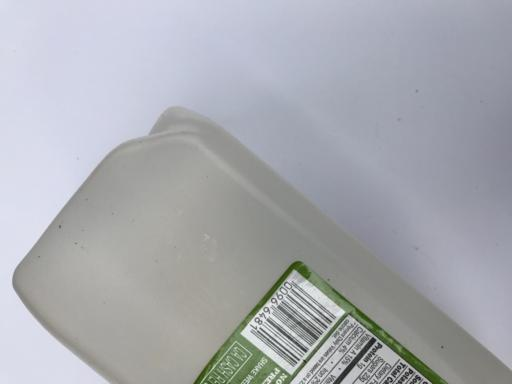

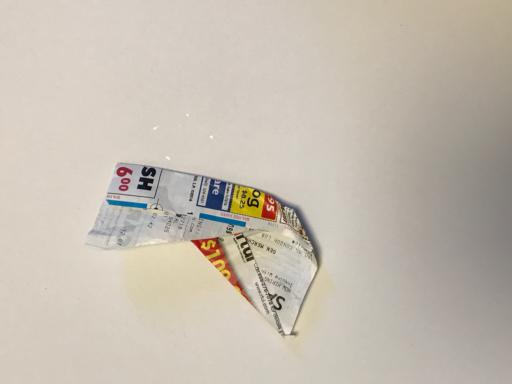

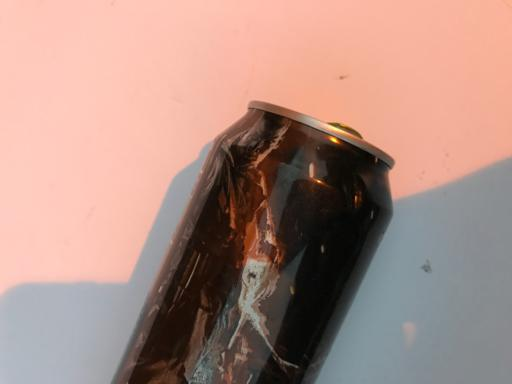

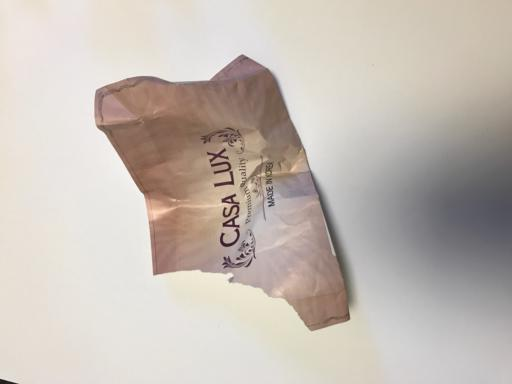

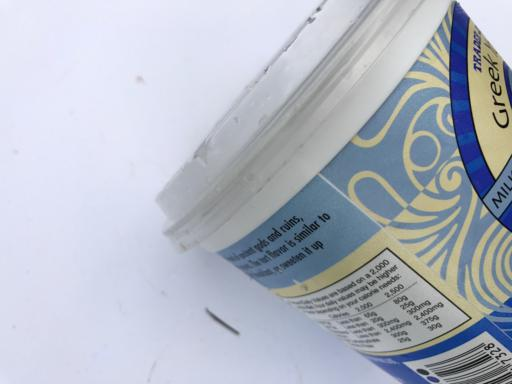

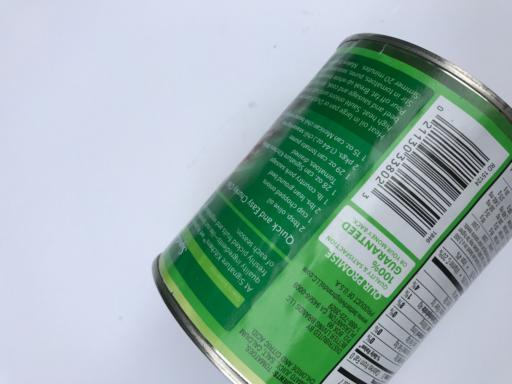

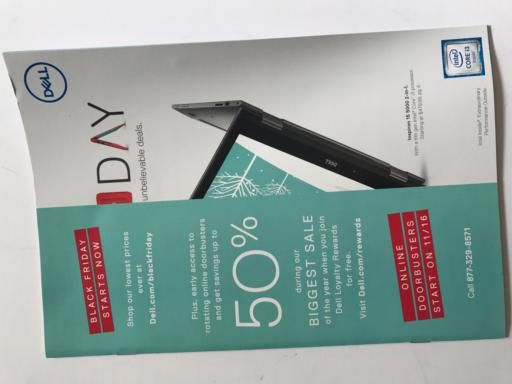

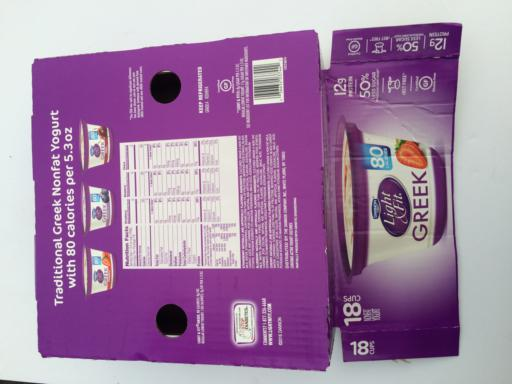

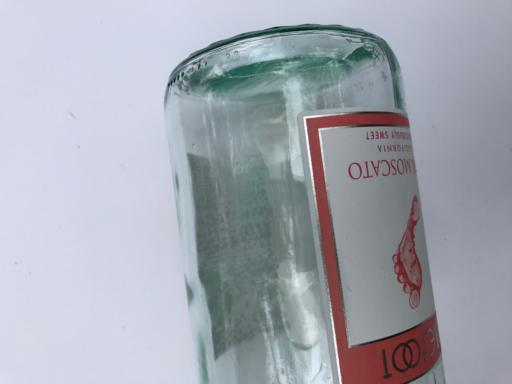

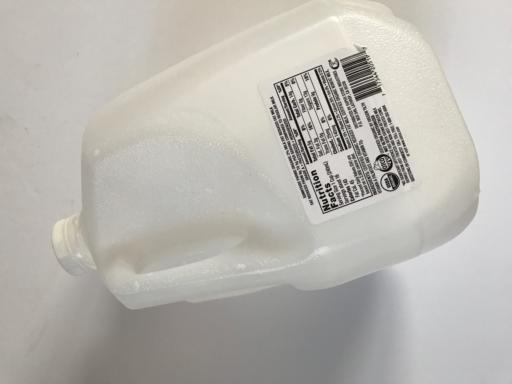

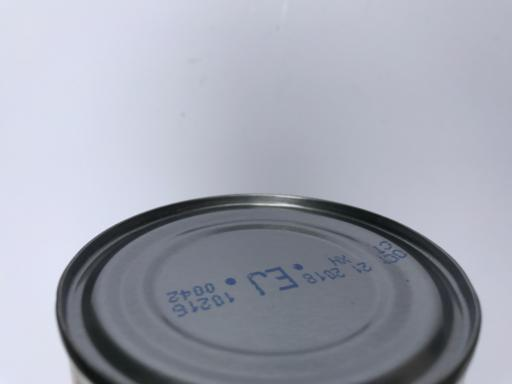

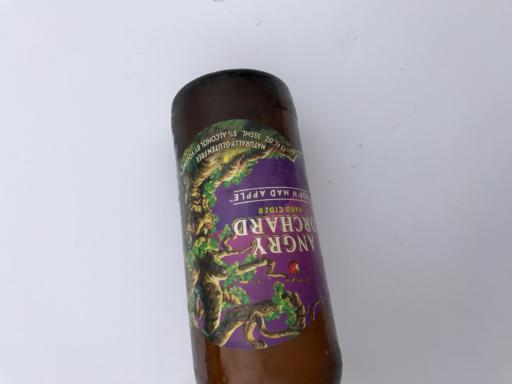

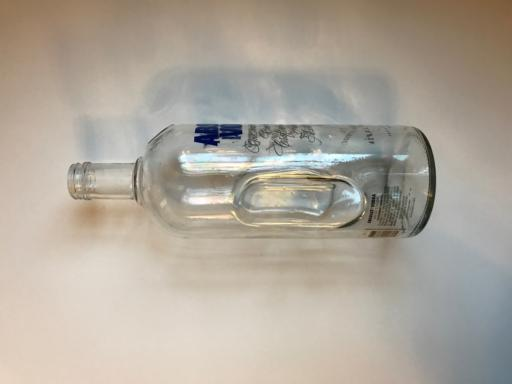

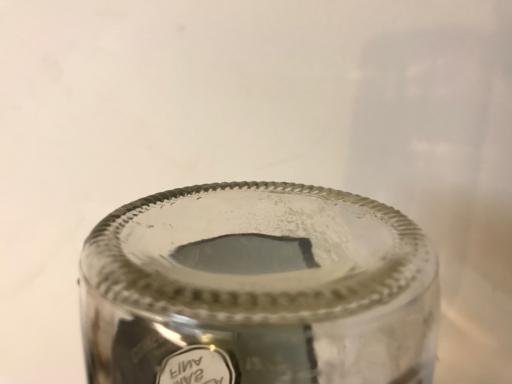

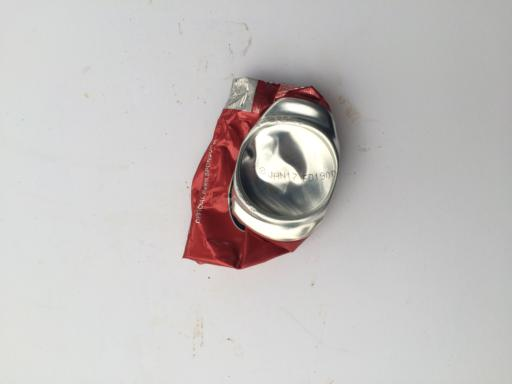

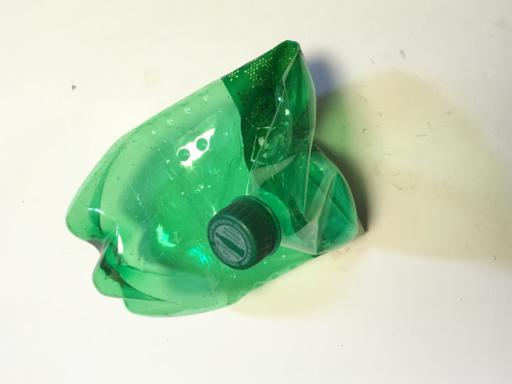

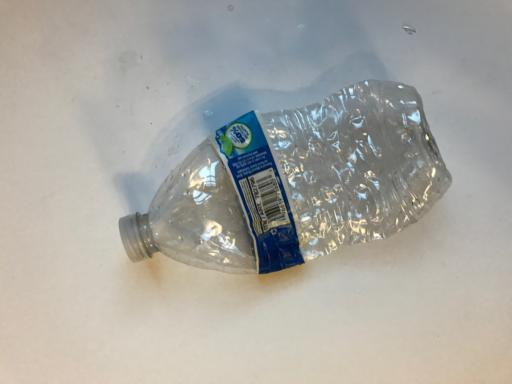

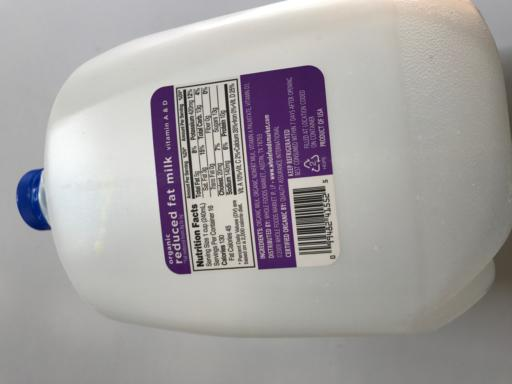

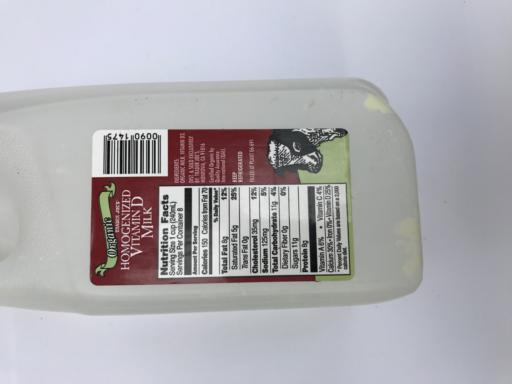

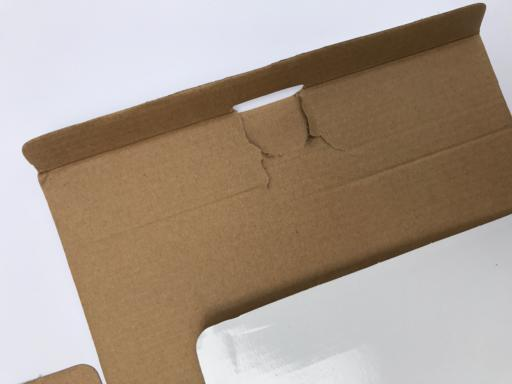

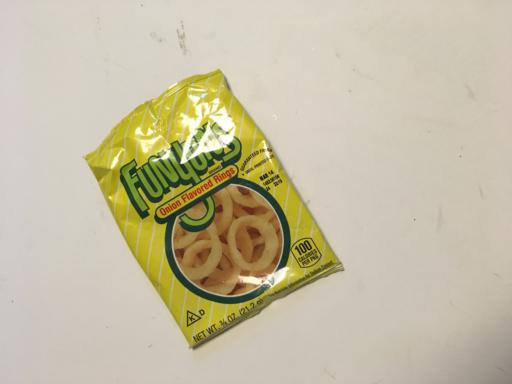

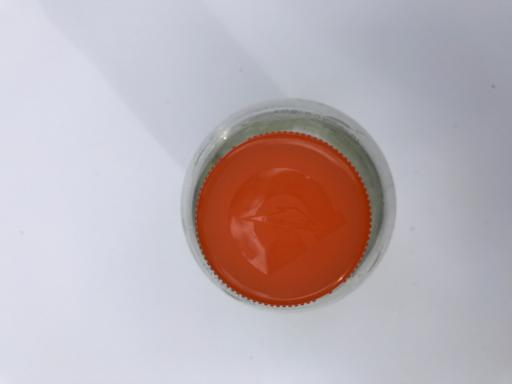

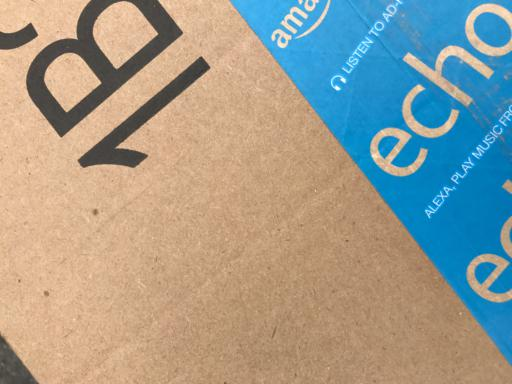

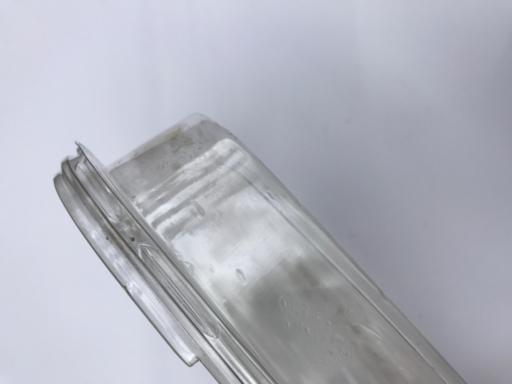

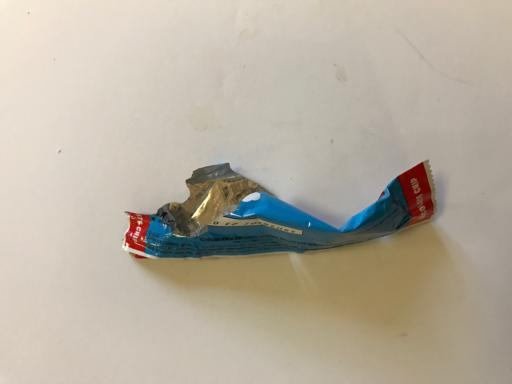

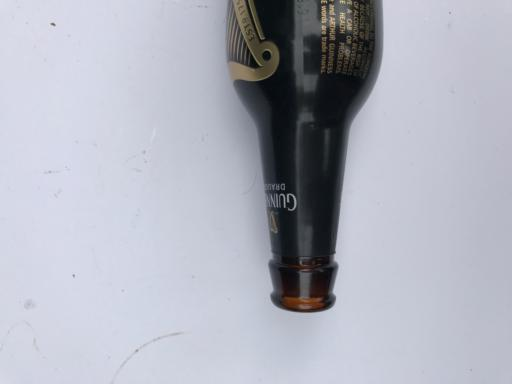

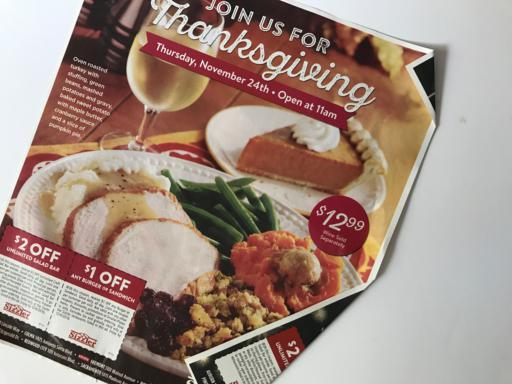

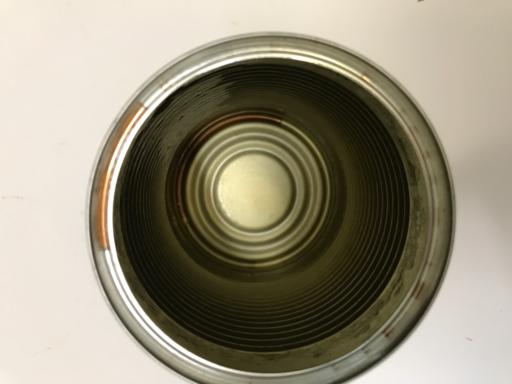

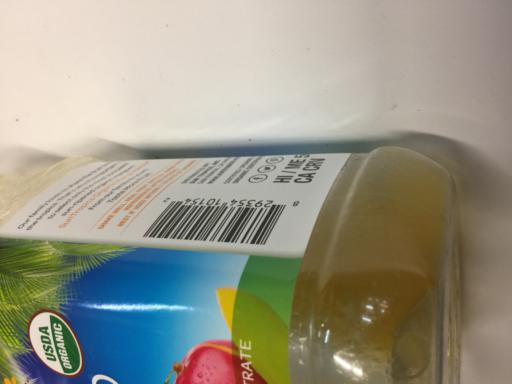

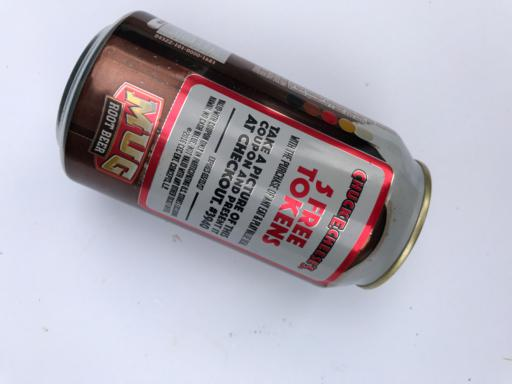

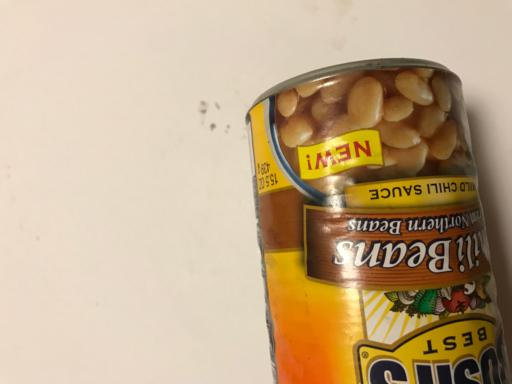

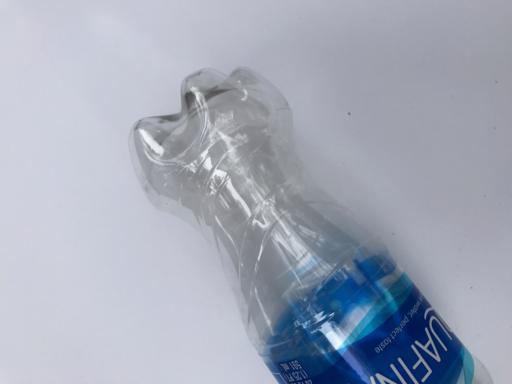

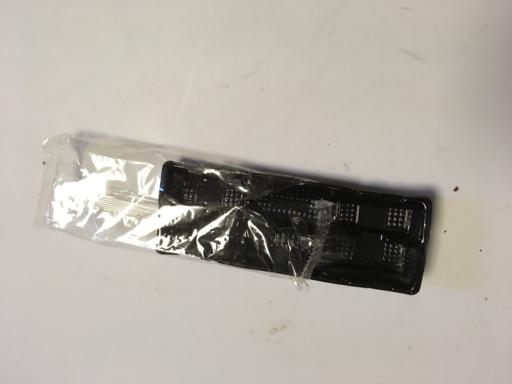

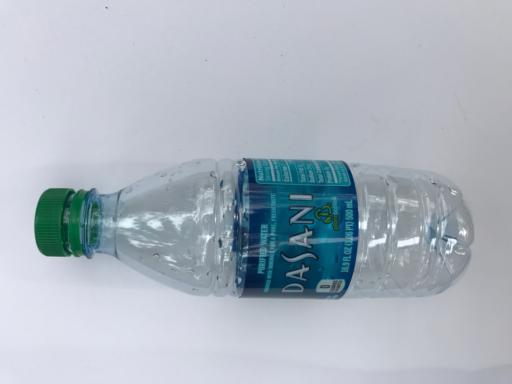

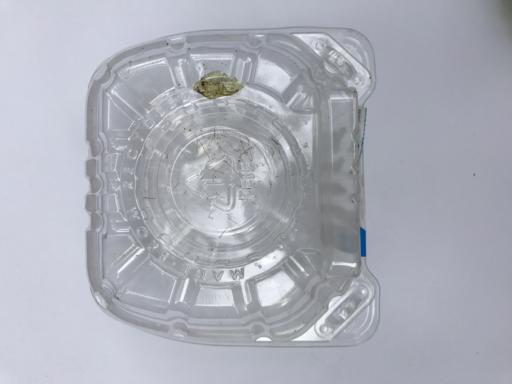

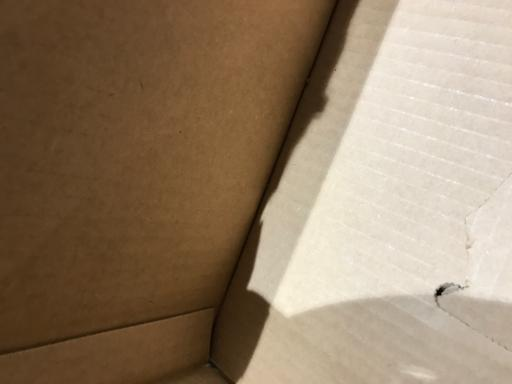

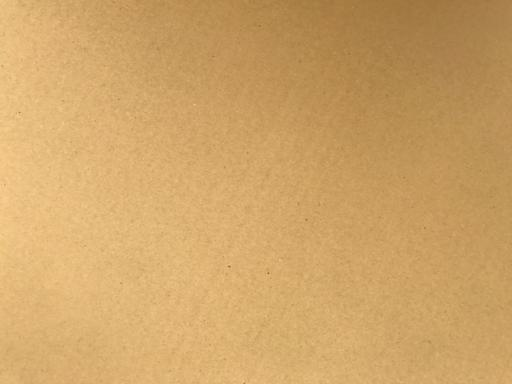

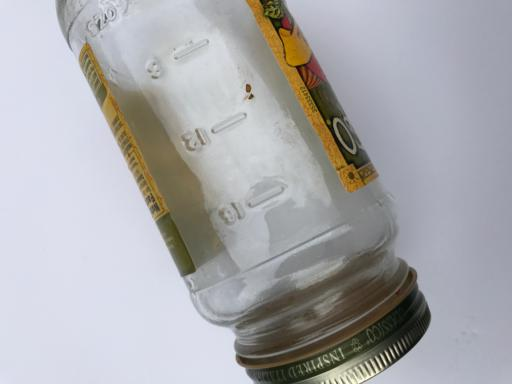

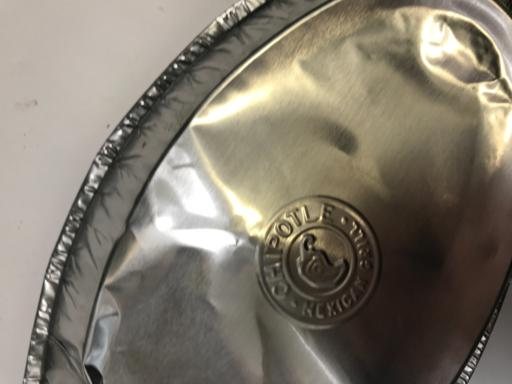

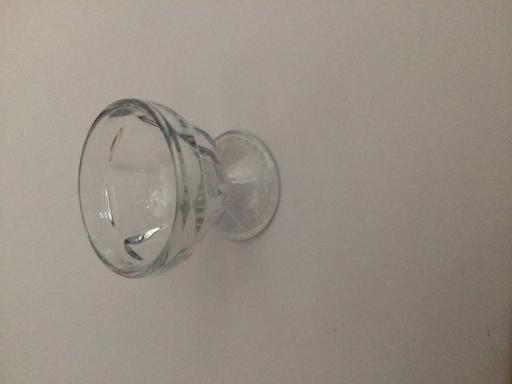

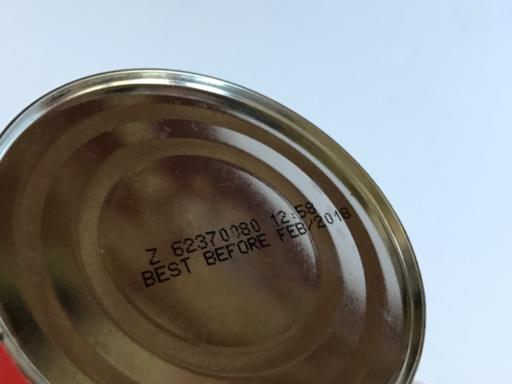

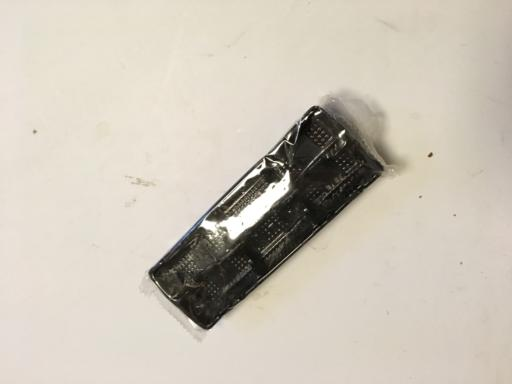

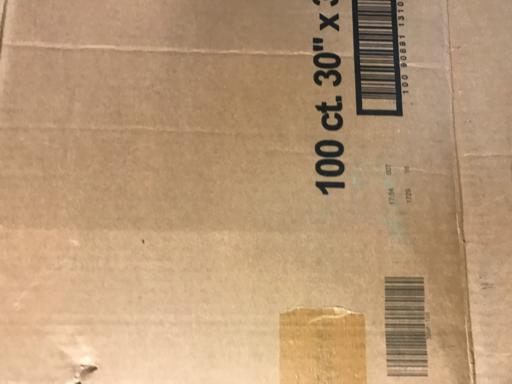

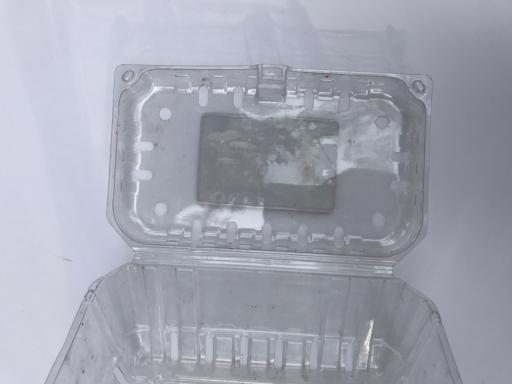

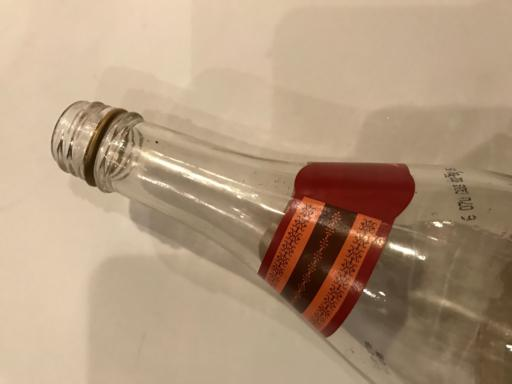

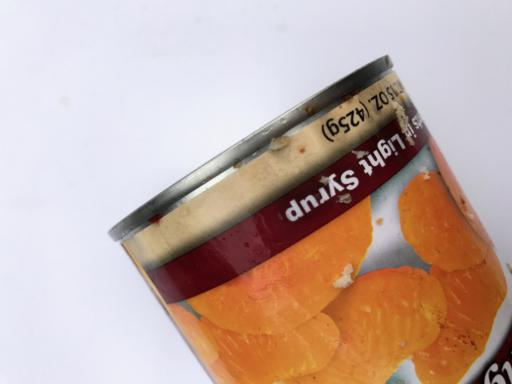

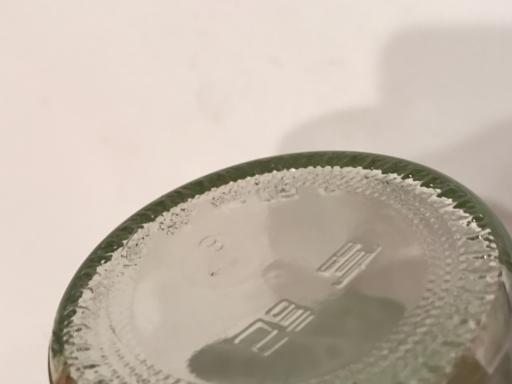

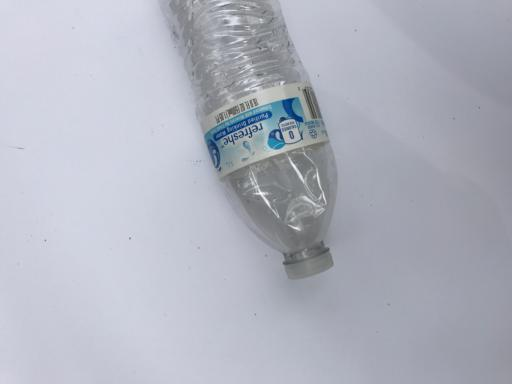

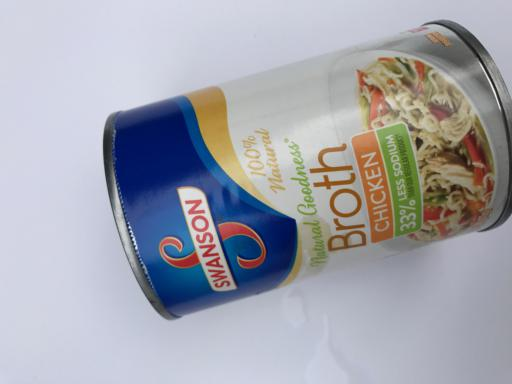

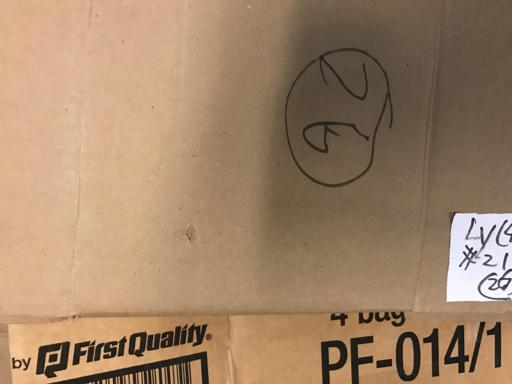

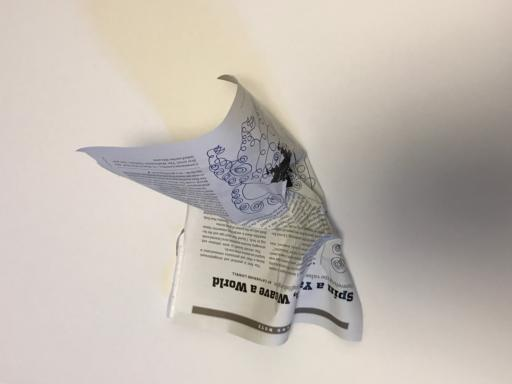

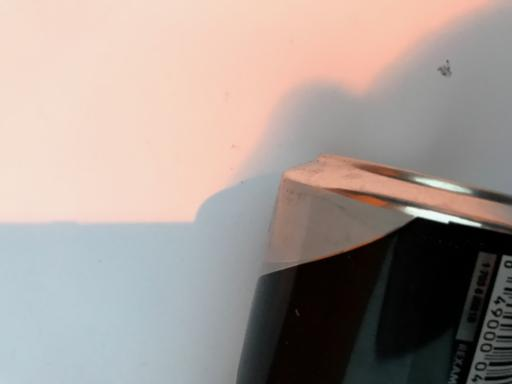

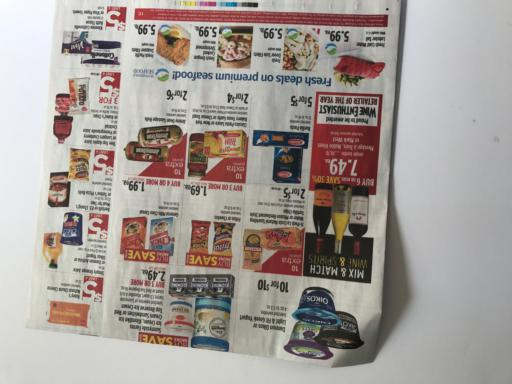

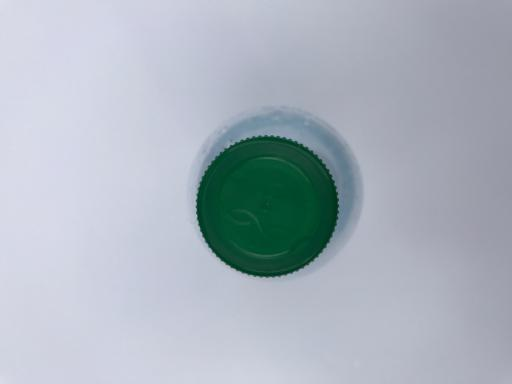

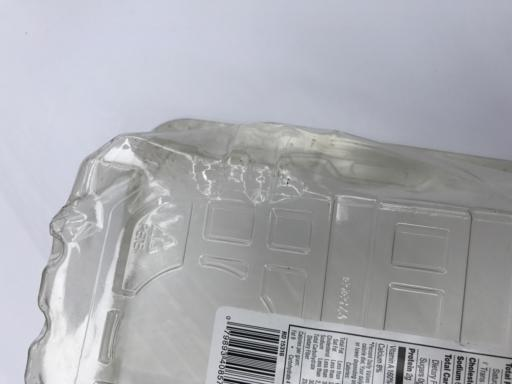

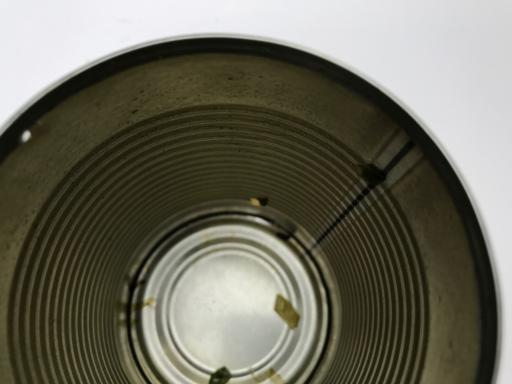

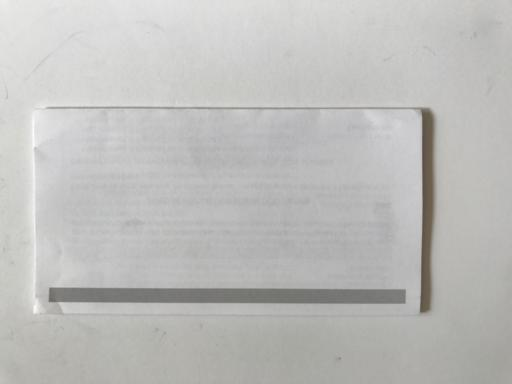

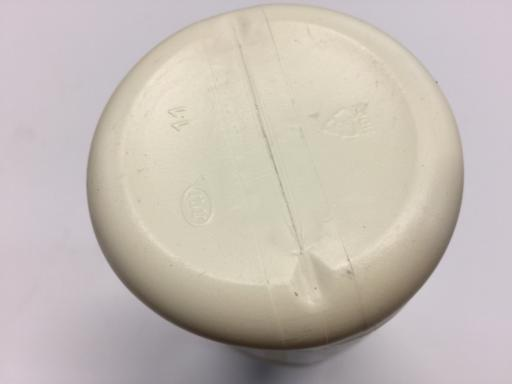

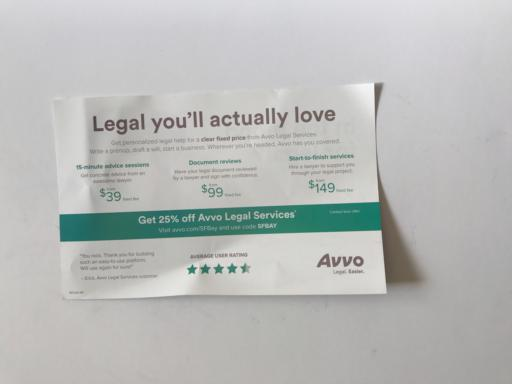

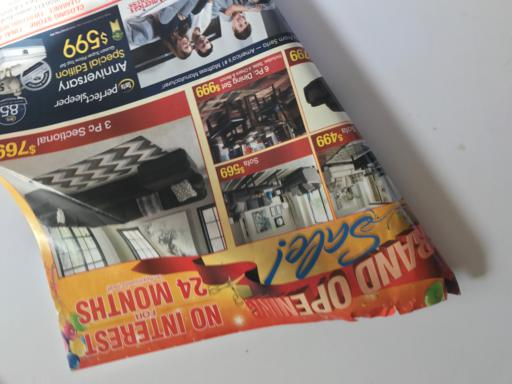

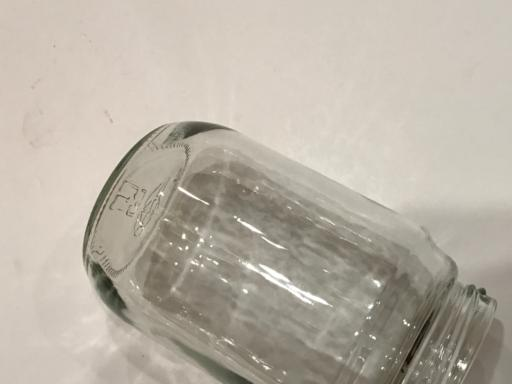

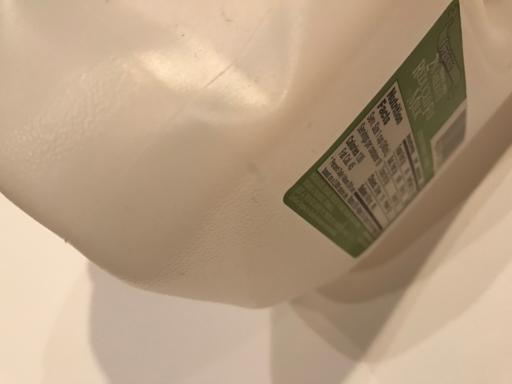

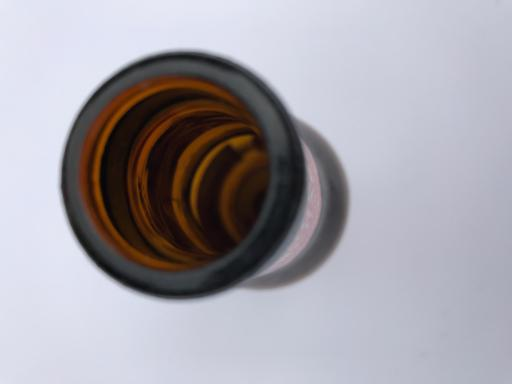

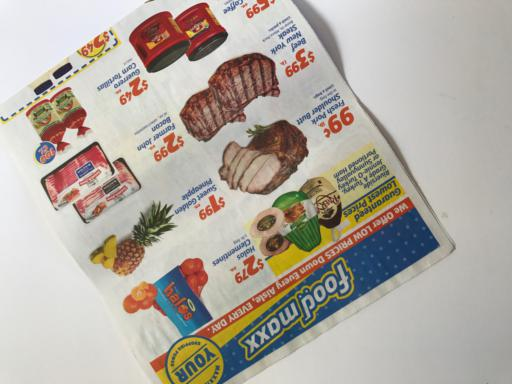

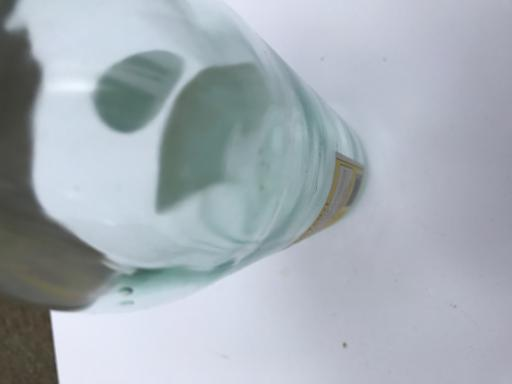

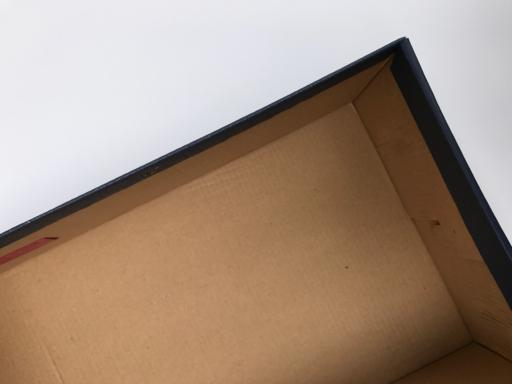

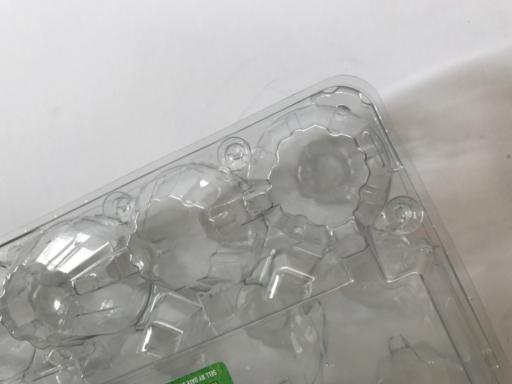

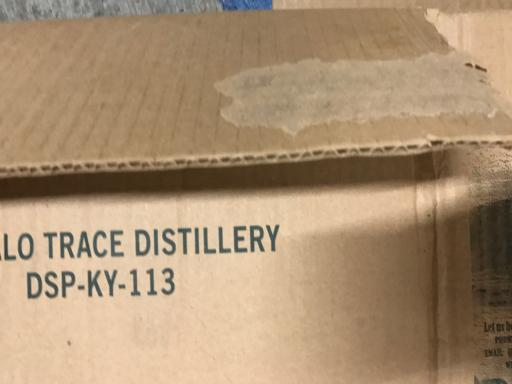

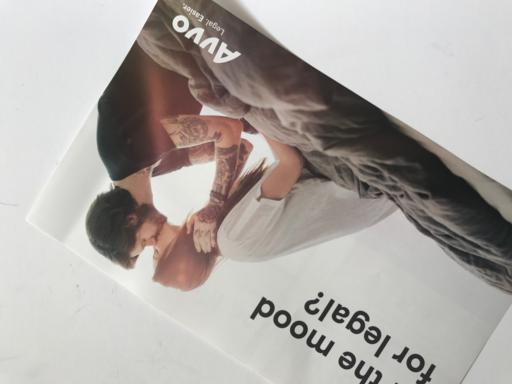

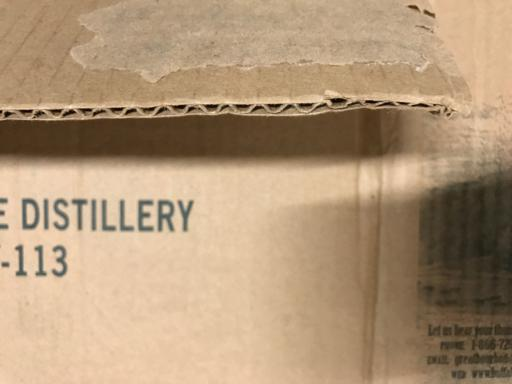

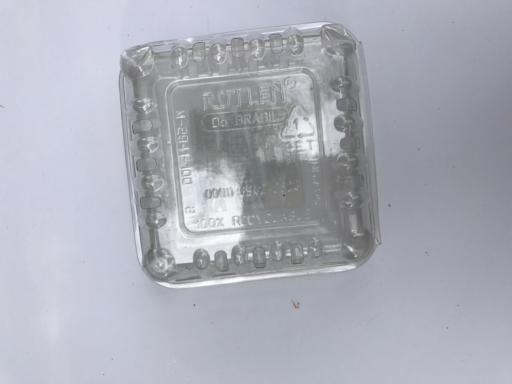

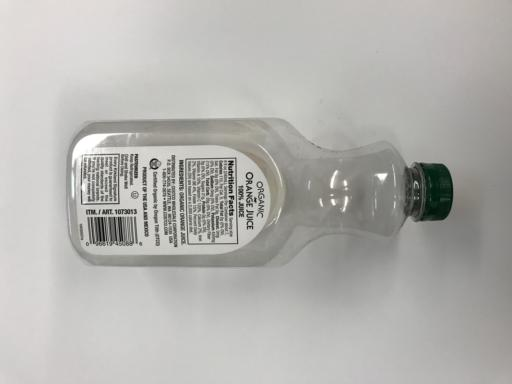

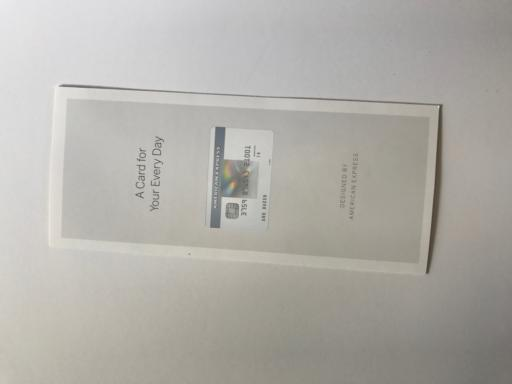

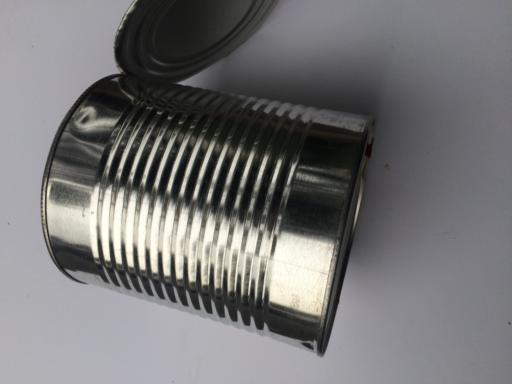

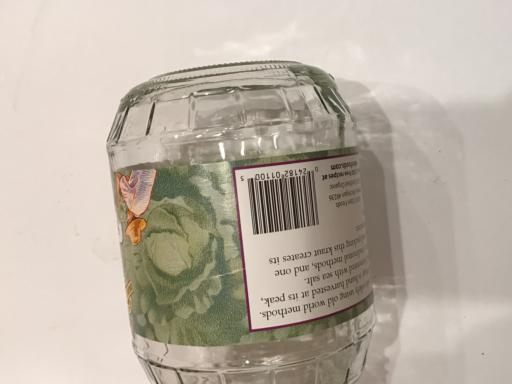

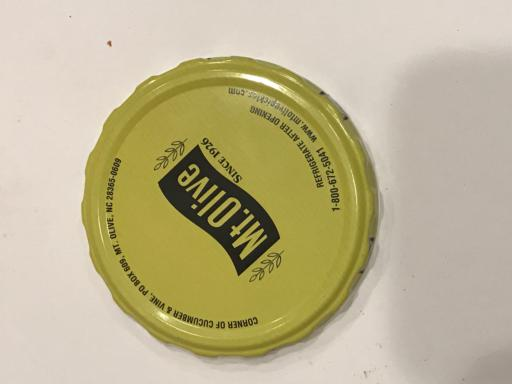

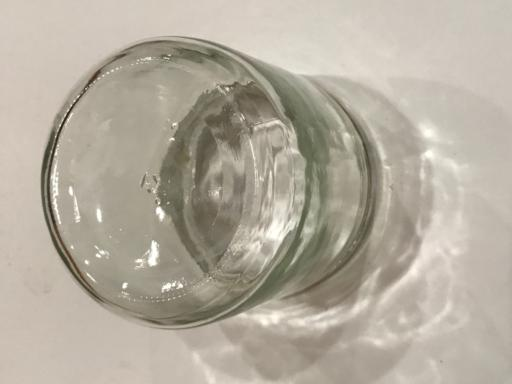

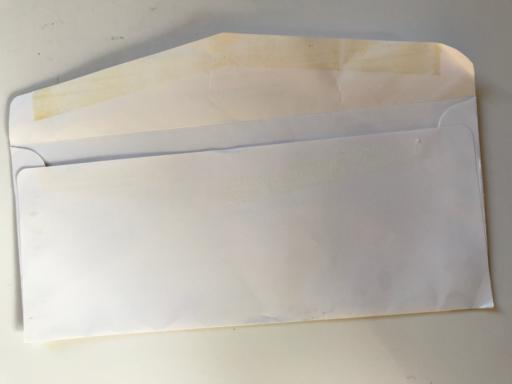

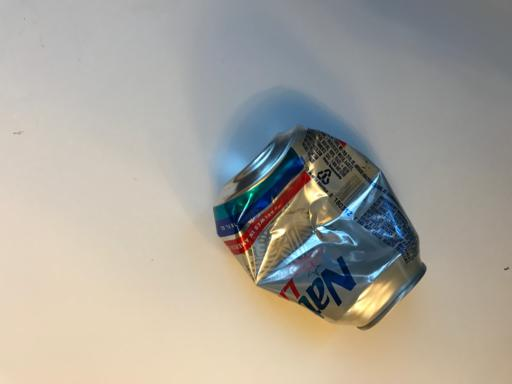

In [ ]:
#display inference on ALL test images
#DO NOT HAVE TO RUN THIS. JUST TO SEE IF IMAGES ARE THERE.
import glob
from IPython.display import Image, display

i = 0
limit = 10000 # max images to print
for imageName in glob.glob('/content/yolov7/data/test/images/*.jpg'): #assuming JPG
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1


In [ ]:
# Run evaluation
#!python detect.py --weights runs/train/yolov7-custom/weights/best.pt --conf 0.1 --source /content/yolov7/data/test/images
!python test.py --data data/data.yaml --img-size 640 --batch-size 16 --conf-thres 0.1 --iou-thres 0.65 --device 0 --weights /content/yolov7/runs/train/yolov7-custom/weights/best.pt --name yolov7_testing --save-json


Namespace(weights=['/content/yolov7/runs/train/yolov7-custom/weights/best.pt'], data='data/data.yaml', batch_size=16, img_size=640, conf_thres=0.1, iou_thres=0.65, task='val', device='0', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project='runs/test', name='yolov7_testing', exist_ok=False, no_trace=False, v5_metric=False)
YOLOR 🚀 v0.1-126-g84932d7 torch 2.0.1+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16150.875MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36508742 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.m